# 미니 경진대회 - 배터리 수명 예측

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.** 

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

In [1]:
# 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# 예시 코드에 필요한 라이브러리를 불러옵니다.
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR


data_dir = "/mnt/elice/dataset"

## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.

In [3]:
train_df = pd.read_csv(os.path.join(data_dir, "train_data.csv"), index_col="Cell_ID")
test_df = pd.read_csv(os.path.join(data_dir, "test_data.csv"), index_col="Cell_ID")

# 테스트 데이터도 학습용 데이터와 같이 'Lifetime' 컬럼이 있지만 값은 비어 있습니다.
# Lifetime 컬럼을 제거해 줍니다.
test_x = test_df.drop(["Lifetime"], axis=1)
train_x = train_df.iloc[:, :-1]
train_y = train_df.iloc[:, -1]

불러온 학습 데이터의 일부를 확인해봅시다.

In [4]:
# 학습 데이터 컬럼의 종류를 확인했습니다.
train_df.columns

Index(['CV_time_0', 'CV_time_3', 'Chg_C-rate', 'Dchg_C-rate', 'DoD', 'Q_ini',
       'Q_ini_V_high', 'Q_ini_V_low', 'Q_ini_V_mid', 'Q_initial', 'avg_stress',
       'capacity_fade_3_0', 'chg_stress', 'dchg_stress', 'delta_CV_time_3_0',
       'delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4',
       'kurt_deltaQ', 'mean_deltaQ_dchg_3_0', 'mean_dqdv_dchg_3_0',
       'mean_dqdv_dchg_high_3_0', 'mean_dqdv_dchg_low_3_0',
       'mean_dqdv_dchg_mid_3_0', 'min_deltaQ', 'multi_stress', 'skew_deltaQ',
       'var_deltaQ', 'var_deltaQ_dchg_3_0', 'var_dqdv_dchg_3_0',
       'var_dqdv_dchg_high_3_0', 'var_dqdv_dchg_low_3_0',
       'var_dqdv_dchg_mid_3_0', 'Lifetime'],
      dtype='object')

In [5]:
# 학습용 데이터의 값의 형태를 일부 확인했습니다.
train_df.head()

,CV_time_0,CV_time_3,Chg_C-rate,Dchg_C-rate,DoD,Q_ini,Q_ini_V_high,Q_ini_V_low,Q_ini_V_mid,Q_initial,...,min_deltaQ,multi_stress,skew_deltaQ,var_deltaQ,var_deltaQ_dchg_3_0,var_dqdv_dchg_3_0,var_dqdv_dchg_high_3_0,var_dqdv_dchg_low_3_0,var_dqdv_dchg_mid_3_0,Lifetime
Cell_ID,,,,,,,,,,,,,,,,,,,,,
1031U,1076.0,859.0,1.8,0.6,0.499119,0.284567,-0.088571,-0.080993,-0.115620,0.284567,...,-0.013893,0.518700,0.934353,0.000042,0.000042,0.001657,0.002272,0.000155,0.002816,14.425
1101F,1090.0,748.0,0.5,0.5,0.976741,0.285810,-0.090005,-0.078695,-0.117403,0.285810,...,-0.010924,0.488371,0.960777,0.000036,0.000036,0.001955,0.002748,0.000290,0.002246,16.805
1138K,1048.0,754.0,1.4,0.5,0.977683,0.287046,-0.091124,-0.079613,-0.116523,0.287046,...,-0.022019,0.817988,0.608444,0.000103,0.000103,0.002099,0.003927,0.000572,0.001171,7.023
1179M,1054.0,757.0,0.8,0.8,0.798062,0.281486,-0.087527,-0.079128,-0.115236,0.281486,...,-0.018387,0.638450,0.697012,0.000079,0.000079,0.001866,0.003187,0.000456,0.001236,10.242
1240W,1011.0,748.0,1.0,0.5,0.965539,0.284278,-0.090426,-0.077865,-0.116357,0.284278,...,-0.015165,0.682739,0.837922,0.000058,0.000058,0.002222,0.004377,0.000295,0.001685,12.827


In [6]:
# 학습용 데이터의 전반적인 정보를 확인합니다.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, 1031U to 9908R
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CV_time_0                116 non-null    float64
 1   CV_time_3                116 non-null    float64
 2   Chg_C-rate               116 non-null    float64
 3   Dchg_C-rate              116 non-null    float64
 4   DoD                      116 non-null    float64
 5   Q_ini                    116 non-null    float64
 6   Q_ini_V_high             116 non-null    float64
 7   Q_ini_V_low              116 non-null    float64
 8   Q_ini_V_mid              116 non-null    float64
 9   Q_initial                116 non-null    float64
 10  avg_stress               116 non-null    float64
 11  capacity_fade_3_0        116 non-null    float64
 12  chg_stress               116 non-null    float64
 13  dchg_stress              116 non-null    float64
 14  delta_CV_time_3_0        

--- 1. 결측치 (Missing Values) 확인 ---
✨ 모든 컬럼에 결측치가 없습니다! ✨

--- 2. 이상치 (Outliers) 확인 (Box Plot) ---


/tmp/ipykernel_424/2762203187.py:42: UserWarning: Glyph 52972 (\N{HANGUL SYLLABLE KEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 전체 레이아웃 조정 (제목 공간 확보)
/tmp/ipykernel_424/2762203187.py:42: UserWarning: Glyph 47100 (\N{HANGUL SYLLABLE REOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 전체 레이아웃 조정 (제목 공간 확보)
/tmp/ipykernel_424/2762203187.py:42: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 전체 레이아웃 조정 (제목 공간 확보)
/tmp/ipykernel_424/2762203187.py:42: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 전체 레이아웃 조정 (제목 공간 확보)
/tmp/ipykernel_424/2762203187.py:42: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 전체 레이아웃 조정 (제목 공간 확보)
/tmp/ipykernel_424/2762203187.py:42: UserWarnin

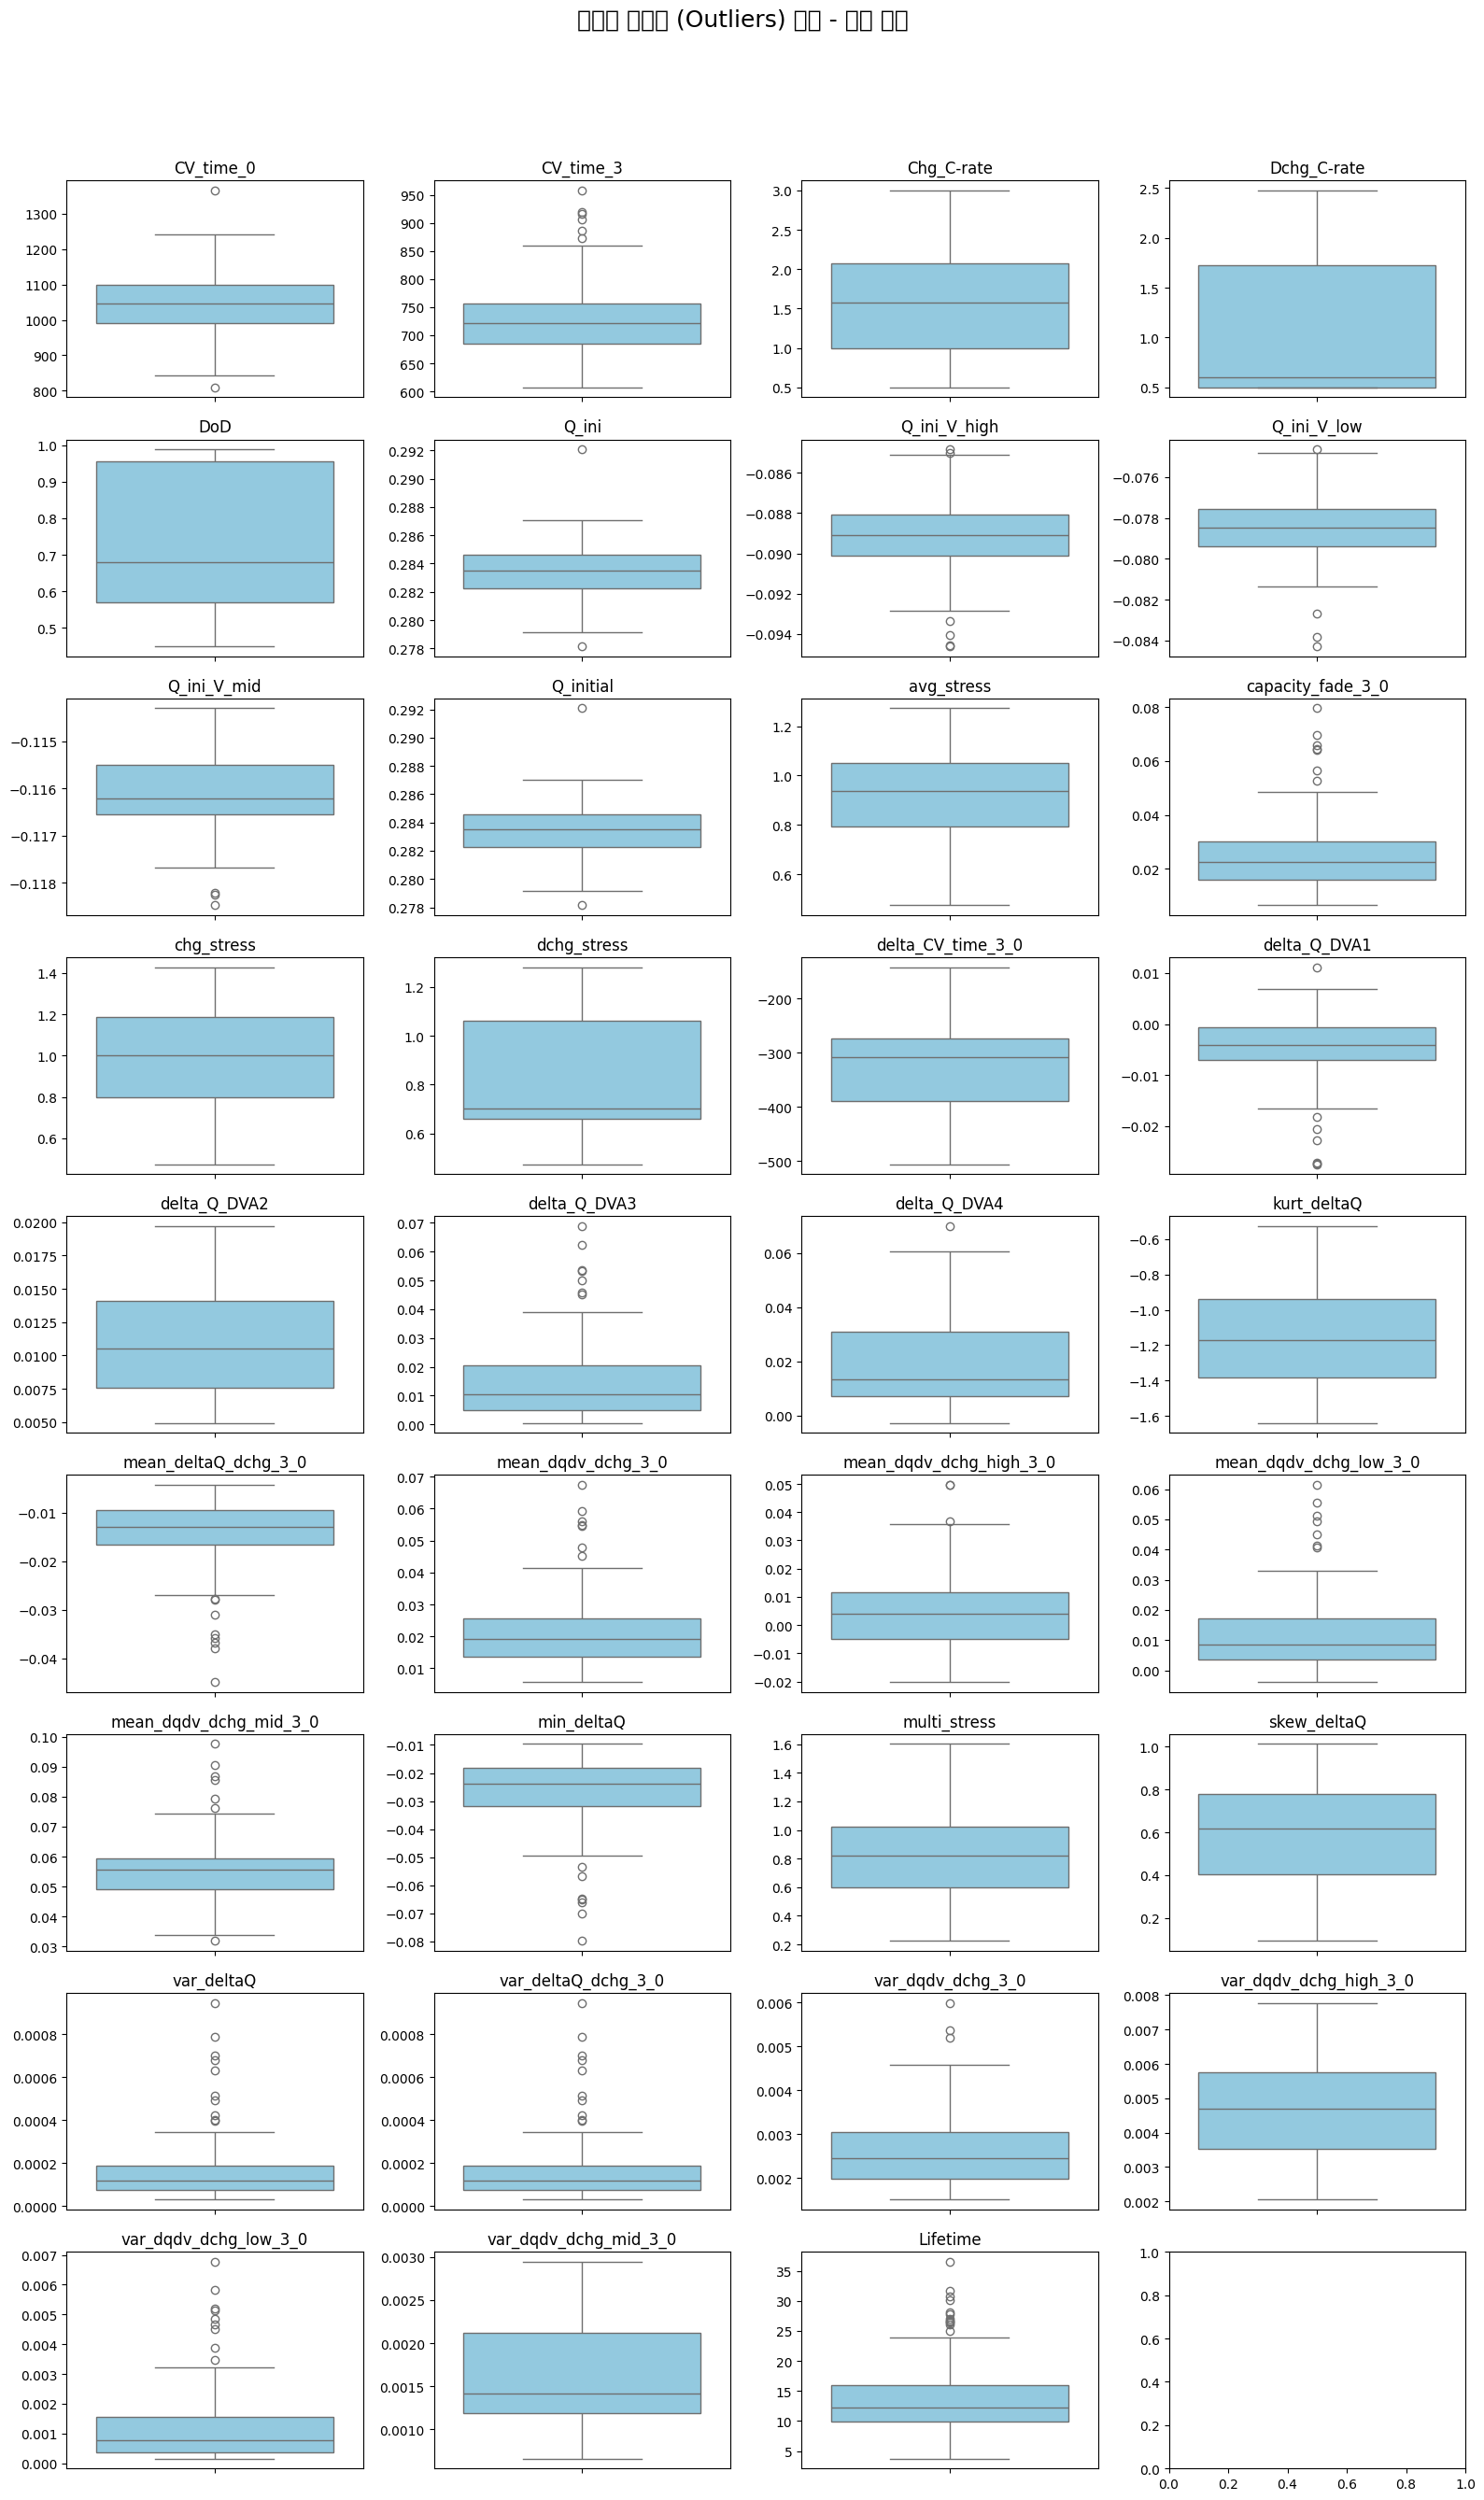


--- 3. 이상치 (Outliers) 확인 (Histogram/KDE) ---


/tmp/ipykernel_424/2762203187.py:64: UserWarning: Glyph 52972 (\N{HANGUL SYLLABLE KEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])
/tmp/ipykernel_424/2762203187.py:64: UserWarning: Glyph 47100 (\N{HANGUL SYLLABLE REOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])
/tmp/ipykernel_424/2762203187.py:64: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])
/tmp/ipykernel_424/2762203187.py:64: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])
/tmp/ipykernel_424/2762203187.py:64: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])
/tmp/ipykernel_424/2762203187.py:64: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])
/tm

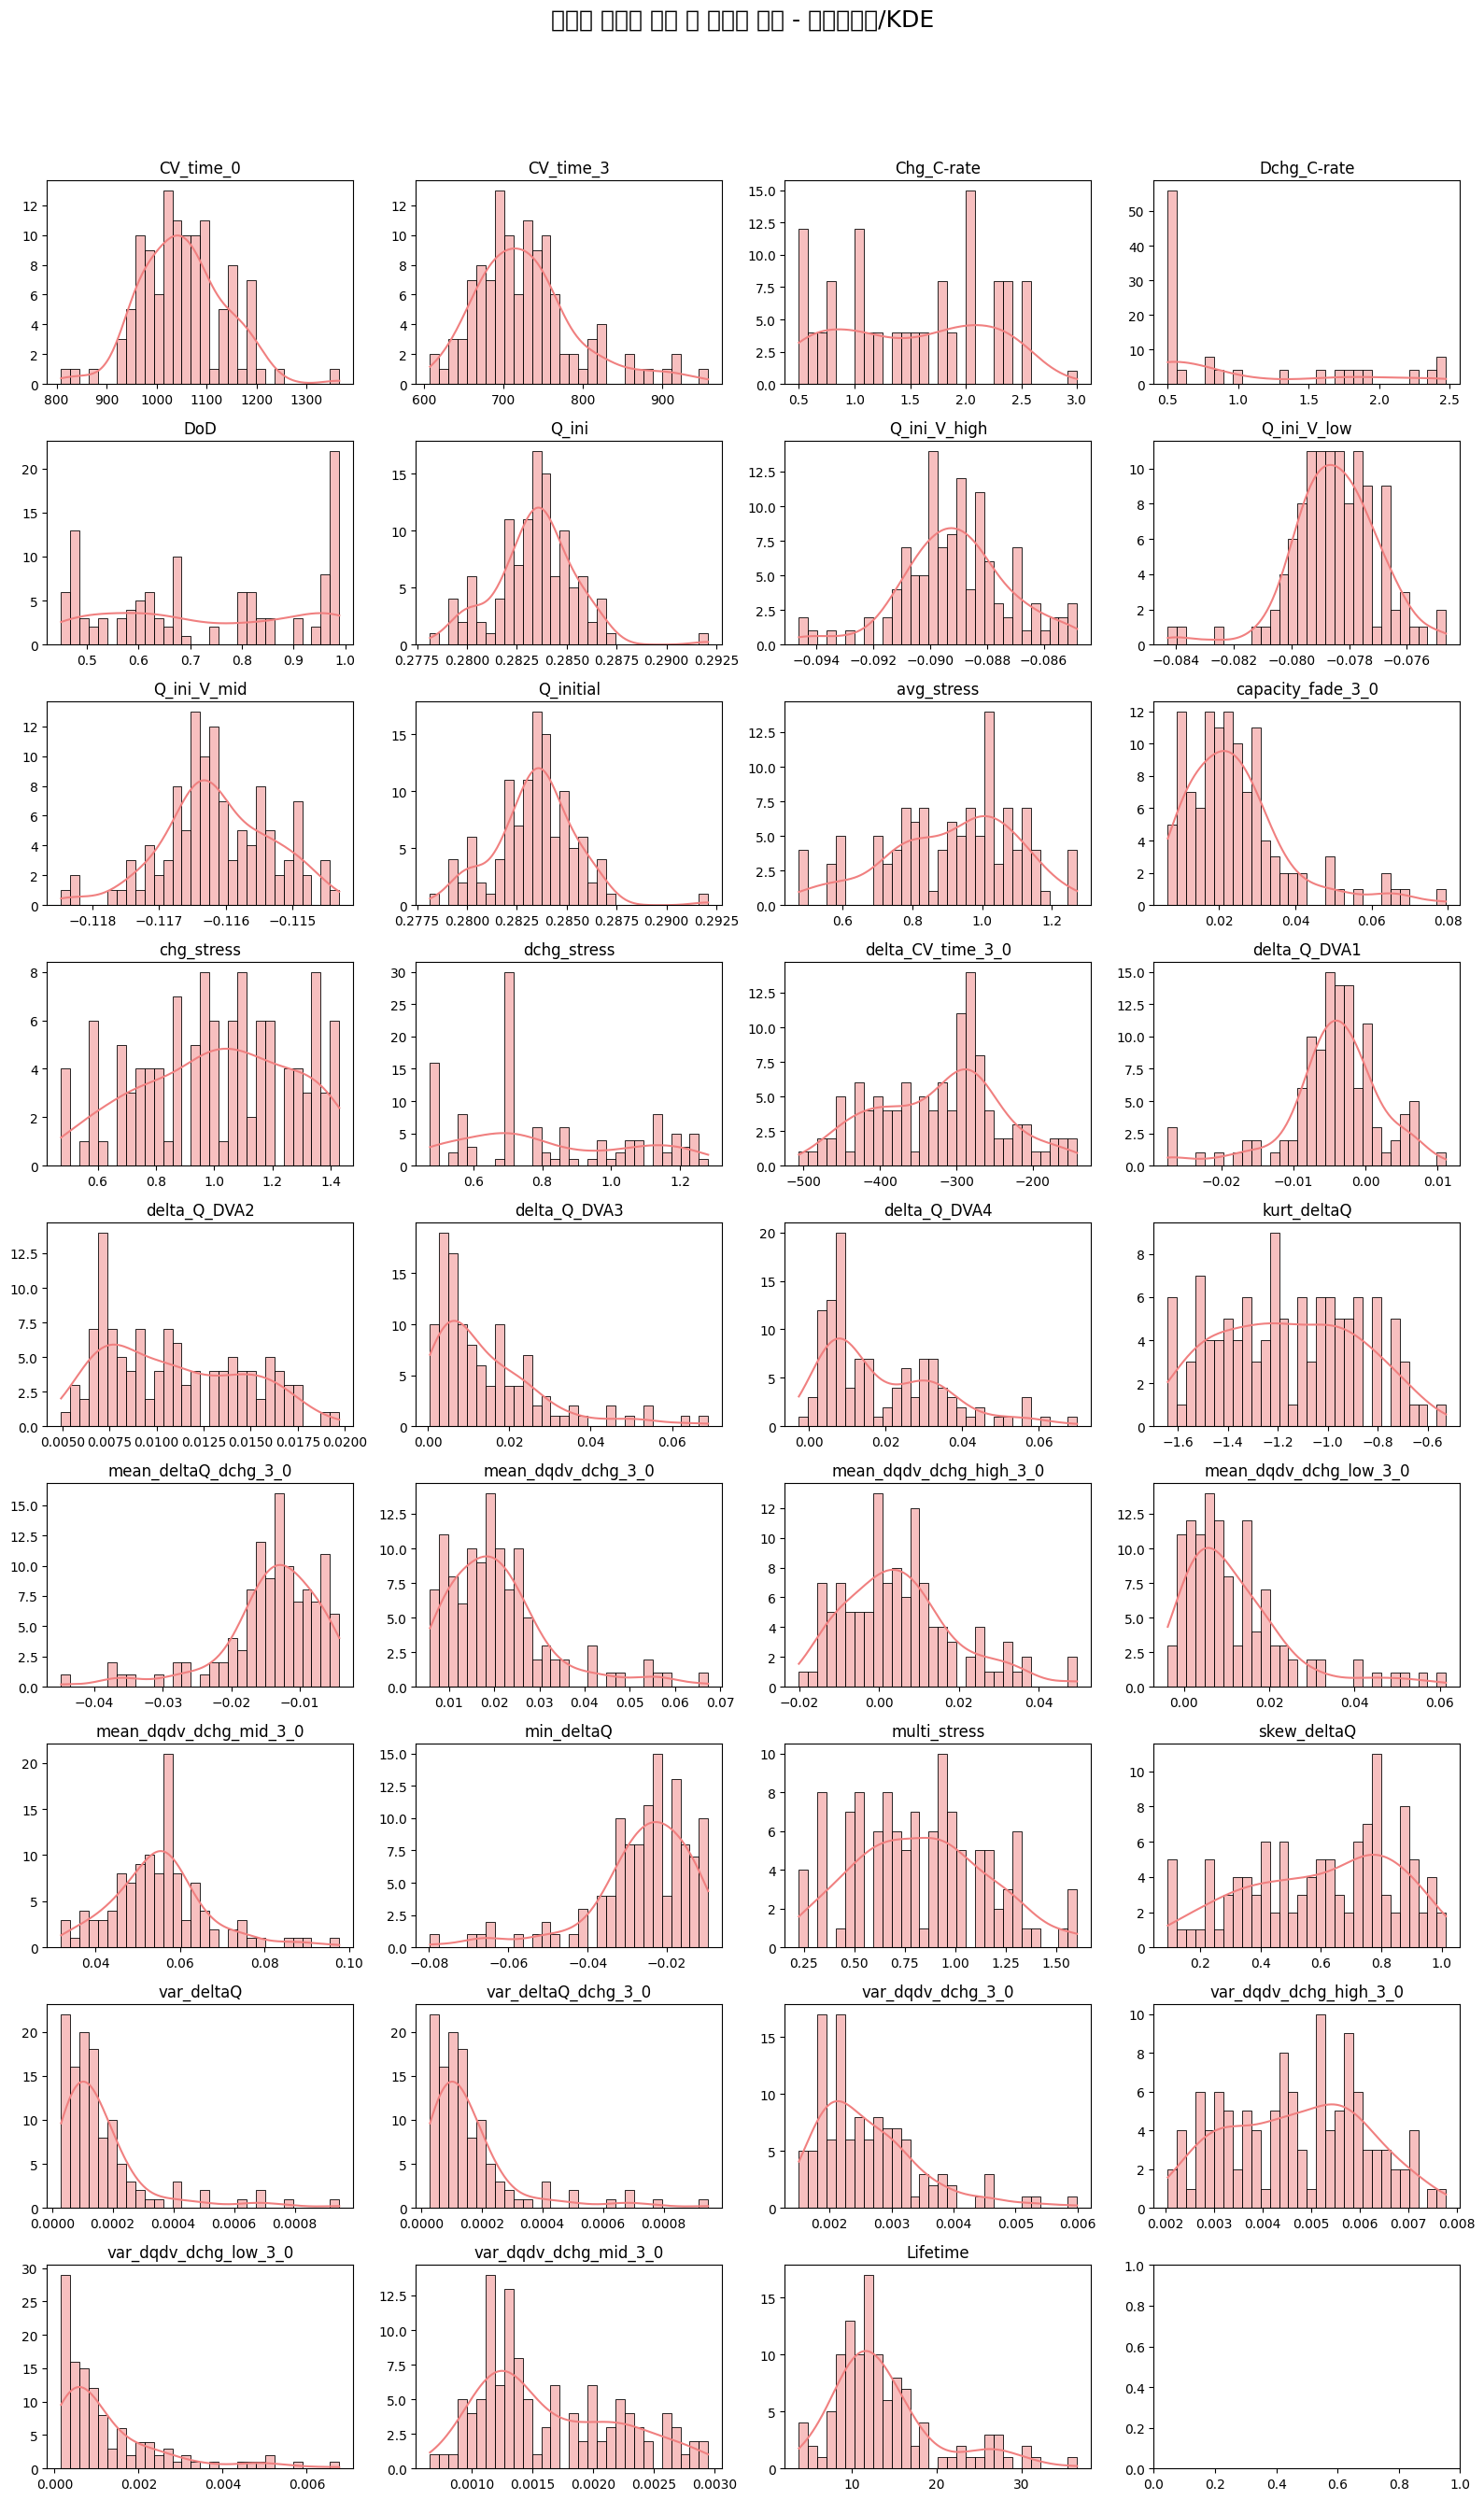

In [7]:
# --- 1. 결측치 확인 ---
print("--- 1. 결측치 (Missing Values) 확인 ---")
missing_values_count = train_df.isnull().sum()
missing_values_percent = (train_df.isnull().sum() / len(train_df)) * 100

missing_info = pd.DataFrame({
    '결측치 개수': missing_values_count,
    '결측치 비율 (%)': missing_values_percent
})
missing_info = missing_info[missing_info['결측치 개수'] > 0].sort_values(by='결측치 비율 (%)', ascending=False)
if missing_info.empty:
    print("✨ 모든 컬럼에 결측치가 없습니다! ✨")
else:
    print(missing_info)
    print("\n결측치에 대한 처리가 필요할 수 있습니다.")


# --- 2. 이상치 (Outliers) 확인 (주요 숫자형 컬럼 대상) ---
print("\n--- 2. 이상치 (Outliers) 확인 (Box Plot) ---")

# 이상치 확인할 컬럼 리스트 (모든 숫자형 컬럼 또는 특정 컬럼 지정)
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()

# 너무 많은 컬럼이 한 번에 그려지면 보기 어려우므로, 3x4 형태로 그래프 배치
n_cols = 4 # 한 줄에 그릴 그래프 수
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
fig.suptitle('컬럼별 이상치 (Outliers) 확인 - 박스 플롯', fontsize=18, y=1.02) # y를 조정하여 제목이 겹치지 않게 함

axes_flat = axes.flatten()

for i, col in enumerate(numeric_cols):
    if i < len(axes_flat): # 서브플롯 개수보다 컬럼이 적을 경우 대비
        sns.boxplot(y=train_df[col], ax=axes_flat[i], color='skyblue')
        axes_flat[i].set_title(col, fontsize=12)
        axes_flat[i].set_ylabel('') # y축 라벨 제거 (깔끔하게)
        axes_flat[i].tick_params(axis='y', labelsize=10) # y축 틱 라벨 크기 조정
    else:
        fig.delaxes(axes_flat[i]) # 남는 서브플롯 제거

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 전체 레이아웃 조정 (제목 공간 확보)
plt.show()

print("\n--- 3. 이상치 (Outliers) 확인 (Histogram/KDE) ---")

# 박스 플롯과 동일한 컬럼들로 히스토그램/KDE 플롯 그리기
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
fig.suptitle('컬럼별 데이터 분포 및 이상치 확인 - 히스토그램/KDE', fontsize=18, y=1.02)

axes_flat = axes.flatten()

for i, col in enumerate(numeric_cols):
    if i < len(axes_flat):
        sns.histplot(train_df[col].dropna(), kde=True, ax=axes_flat[i], color='lightcoral', bins=30)
        axes_flat[i].set_title(col, fontsize=12)
        axes_flat[i].set_xlabel('')
        axes_flat[i].set_ylabel('')
        axes_flat[i].tick_params(axis='y', labelsize=10)
        axes_flat[i].tick_params(axis='x', labelsize=10)
    else:
        fig.delaxes(axes_flat[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


전체적인 컬럼의 상관관계를 파악합니다.
변수가 많으므로 상관계수로만 확인합니다.

1. 변수 간의 관계 파악 및 중요 변수 식별

In [8]:
# 1. 상관계수 계산
correlation_matrix = train_df.corr()

# 2. 'Lifetime' 컬럼과의 상관관계만 추출하여 정렬
lifetime_correlations = correlation_matrix['Lifetime'].sort_values(ascending=False)

print("--- 'Lifetime' 컬럼과의 상관관계 (높은 순서대로 정렬) ---")
print(lifetime_correlations)

--- 'Lifetime' 컬럼과의 상관관계 (높은 순서대로 정렬) ---
Lifetime                   1.000000
mean_deltaQ_dchg_3_0       0.576595
min_deltaQ                 0.563383
kurt_deltaQ                0.464597
skew_deltaQ                0.416584
var_dqdv_dchg_mid_3_0      0.285562
Q_ini_V_high               0.231746
CV_time_0                  0.135210
Q_ini_V_mid                0.041512
CV_time_3                 -0.049325
delta_Q_DVA1              -0.093573
Q_ini                     -0.116545
Q_initial                 -0.116545
Q_ini_V_low               -0.124679
delta_CV_time_3_0         -0.179394
Dchg_C-rate               -0.268994
Chg_C-rate                -0.314154
delta_Q_DVA4              -0.368100
mean_dqdv_dchg_low_3_0    -0.400738
delta_Q_DVA2              -0.433065
var_dqdv_dchg_low_3_0     -0.435499
var_dqdv_dchg_high_3_0    -0.454951
delta_Q_DVA3              -0.462972
dchg_stress               -0.482376
mean_dqdv_dchg_high_3_0   -0.492854
DoD                       -0.497260
var_deltaQ_dchg_3_0   

각 컬럼의 관계를 파악합니다.

1. 0주차 충전시간 vs 3주차 충전시간

: 산점도를 통해 시간이 지남에 따라 충전시간이 어떻게 변하는지 확인합니다.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 33 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fo

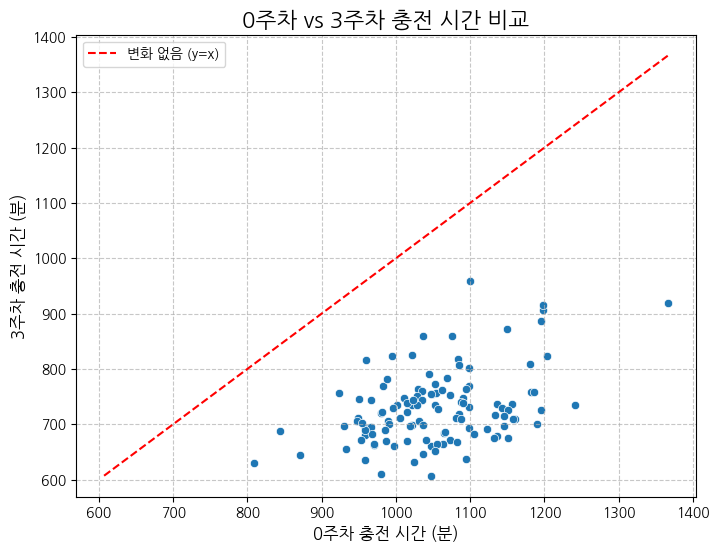

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib # Matplotlib 캐시 삭제 (필수!)
plt.rcParams['font.family'] = 'NanumGothic'

# 윈도우 환경(맑은 고딕)

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(8, 6)) # 그래프의 크기를 설정 (가로 8인치, 세로 6인치)

# 산점도 그리기
# x축: 0주차에서 특정 레벨까지 충전되는 데 걸리는 시간
# y축: 3주차에서 특정 레벨까지 충전되는 데 걸리는 시간
sns.scatterplot(x='CV_time_0', y='CV_time_3', data=train_df)

# 대각선 (y=x) 추가: 둘의 시간이 같다면 점이 대각선 위에 있을 것입니다.
plt.plot([min(train_df['CV_time_0'].min(), train_df['CV_time_3'].min()),
          max(train_df['CV_time_0'].max(), train_df['CV_time_3'].max())],# X축에 찍을 두 점의 좌표
         [min(train_df['CV_time_0'].min(), train_df['CV_time_3'].min()), # y축에 찍을 두 점의 좌표
          max(train_df['CV_time_0'].max(), train_df['CV_time_3'].max())],
         color='red', linestyle='--', label='변화 없음 (y=x)')

# 그래프 제목과 축 라벨 설정
plt.title('0주차 vs 3주차 충전 시간 비교', fontsize=16)
plt.xlabel('0주차 충전 시간 (분)', fontsize=12)
plt.ylabel('3주차 충전 시간 (분)', fontsize=12)

# 그리드(격자) 추가하여 값 확인 용이하게
plt.grid(True, linestyle='--', alpha=0.7)

# 범례 표시 (대각선 라벨을 보여주기 위해)
plt.legend()

# 그래프 보여주기
plt.show()

시간이 지남에 따라 충전시간이 늘어날 것이라고 생각했는데 산점도의 결과를 보니 시간이 지남에 따라 충전시간이 감소했습니다.

그렇다면 Lifetime과 충전시간의 관계는 어떤지 한번 확인해보겠습니다.

2. Lifetime vs 충전 시간 변화량

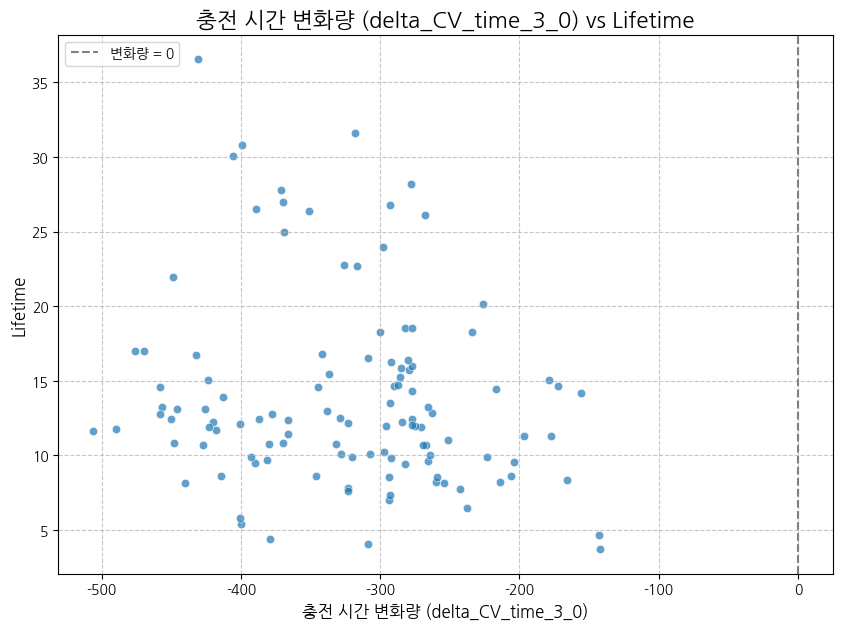


'delta_CV_time_3_0'과 'Lifetime' 간의 상관계수: -0.18


In [10]:
plt.figure(figsize=(10, 7)) # 그래프 크기 설정

# 산점도 그리기
# X축: delta_CV_time_3_0
# Y축: Lifetime
sns.scatterplot(x='delta_CV_time_3_0', y='Lifetime', data=train_df, alpha=0.7) # alpha로 투명도 설정 (점이 많을 때 유용)

# 그래프 제목과 축 라벨 설정
plt.title('충전 시간 변화량 (delta_CV_time_3_0) vs Lifetime', fontsize=16)
plt.xlabel('충전 시간 변화량 (delta_CV_time_3_0)', fontsize=12) # 컬럼의 실제 의미에 맞춰 라벨 조정 필요
plt.ylabel('Lifetime', fontsize=12)

# X축 0에 수직선 추가: 변화량이 0인 지점 (0주차와 3주차 시간이 같을 때)
plt.axvline(x=0, color='grey', linestyle='--', label='변화량 = 0')

# 그리드(격자) 추가
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend() # 범례 표시

# 그래프 보여주기
plt.show()

# 3. 추가적으로 'delta_CV_time_3_0'와 'Lifetime' 간의 상관계수도 확인
correlation_delta_lifetime = train_df['delta_CV_time_3_0'].corr(train_df['Lifetime'])
print(f"\n'delta_CV_time_3_0'과 'Lifetime' 간의 상관계수: {correlation_delta_lifetime:.2f}")

상관관계가 매우 약한 것으로 보입니다. 
그럼 이건 
1. 두 변수 사이의 관계가 없거나
2. 비선형적인 관계가 있거나 
인 것 같습니다.

비선형적인 관계가 있는지 확인해봅니다.

delta_CV_time_3_0 기술통계:
count    116.000000
mean    -323.491379
std       82.668904
min     -506.000000
25%     -389.250000
50%     -309.000000
75%     -274.000000
max     -142.000000
Name: delta_CV_time_3_0, dtype: float64

delta_CV_time_3_0 최소값: -506.0
delta_CV_time_3_0 최대값: -142.0


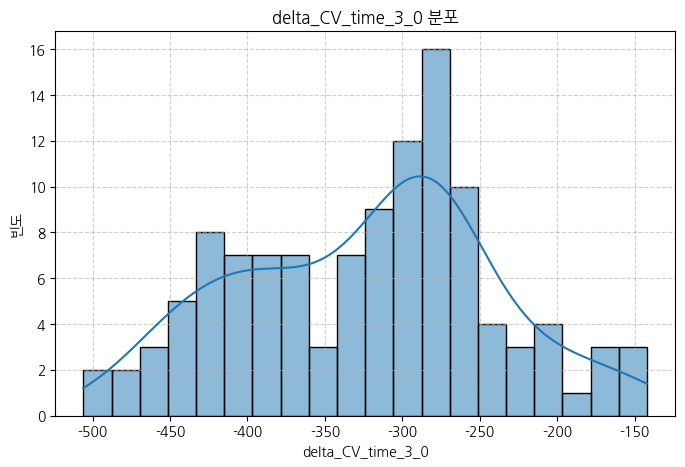

In [11]:
# --- 1. 'delta_CV_time_3_0' 컬럼의 분포 확인 (구간 설정을 위해) ---
print(f"delta_CV_time_3_0 기술통계:\n{train_df['delta_CV_time_3_0'].describe()}")
print(f"\ndelta_CV_time_3_0 최소값: {train_df['delta_CV_time_3_0'].min()}")
print(f"delta_CV_time_3_0 최대값: {train_df['delta_CV_time_3_0'].max()}")

# 히스토그램으로 분포 시각화 (구간 나누기 전 참고용)
plt.figure(figsize=(8, 5))
sns.histplot(train_df['delta_CV_time_3_0'], kde=True, bins=20)
plt.title('delta_CV_time_3_0 분포')
plt.xlabel('delta_CV_time_3_0')
plt.ylabel('빈도')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

그래프의 빈도가 일정하지 않고 들쭉날쭉합니다. 
그러니까 상관성이 없는 게 아니라 단지 비선형적인 패턴이기 때문에 상관계수가 낮게 나왔다고 생각해볼 수 있습니다.

데이터를 의미있는 덩어리로 나눠 Lifetime에 어떤 영향을 미치는지 세분화하여 탐색하기 위해서 구간을 나누겠습니다. 

In [12]:
# 데이터의 분위수에 따라 4개 구간으로 나누기
train_df['delta_CV_time_3_0_bin'] = pd.qcut(train_df['delta_CV_time_3_0'], q=4,
                                       labels=['Q1 (가장 많이 단축)', 'Q2(많이 단축)', 'Q3(적당히 단축)', 'Q4 (가장 적게 단축)'],
                                       duplicates='drop') # 중복 경계값 처리


print("\n--- 'delta_CV_time_3_0' 구간별 데이터 개수 ---")
print(train_df['delta_CV_time_3_0_bin'].value_counts().sort_index())


--- 'delta_CV_time_3_0' 구간별 데이터 개수 ---
delta_CV_time_3_0_bin
Q1 (가장 많이 단축)    29
Q2(많이 단축)        30
Q3(적당히 단축)       28
Q4 (가장 적게 단축)    29
Name: count, dtype: int64


/tmp/ipykernel_424/2292075991.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='delta_CV_time_3_0_bin', y='Lifetime', data=train_df, palette='viridis')


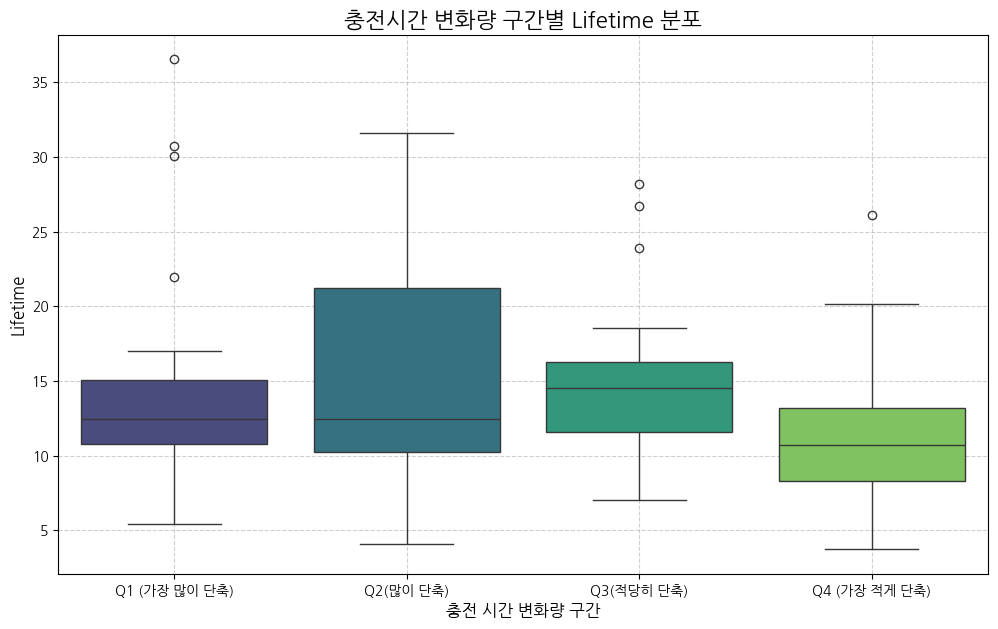


--- 충전시간 변화량 구간별 Lifetime 통계 ---
                            mean  median       std
delta_CV_time_3_0_bin                             
Q1 (가장 많이 단축)          14.430621  12.436  7.144017
Q2(많이 단축)              15.140267  12.473  7.488215
Q3(적당히 단축)             14.643357  14.506  5.242018
Q4 (가장 적게 단축)          11.299759  10.717  4.609466


/tmp/ipykernel_424/2292075991.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_df.groupby('delta_CV_time_3_0_bin')['Lifetime'].agg(['mean', 'median', 'std']))


In [13]:

# --- 3. 구간별 'Lifetime' 박스플롯 그리기 ---
plt.figure(figsize=(12, 7))

sns.boxplot(x='delta_CV_time_3_0_bin', y='Lifetime', data=train_df, palette='viridis')

plt.title('충전시간 변화량 구간별 Lifetime 분포', fontsize=16)
plt.xlabel('충전 시간 변화량 구간', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 4. (선택) 구간별 Lifetime 평균/중앙값 확인 ---
print("\n--- 충전시간 변화량 구간별 Lifetime 통계 ---")
print(train_df.groupby('delta_CV_time_3_0_bin')['Lifetime'].agg(['mean', 'median', 'std']))

delta_CV_time_3_0과 Lifetime은 선형적인 관계는 아니지만, Q3에서 Lifetime에 유의미한 영향을 미치고 있다고 볼 수 있습니다.

즉, 충전 시간이 너무 많이 줄어드는 것도(Q1), 너무 적게 줄어드는 것도(Q4) 수명에는 부정적이거나 덜 긍정적이고, '적당히 단축'되는 것이 가장 긴 수명과 연관되어 있다는 가설을 세울 수 있습니다.

Q2 그룹은 평균은 높지만 중앙값은 Q3보다 낮은데, 이는 Q2 그룹에 매우 높은 Lifetime을 가진 몇몇 배터리 셀(이상치)이 존재하여 평균을 높였을 가능성을 시사해. 이 이상치들을 추가로 분석해보면 흥미로운 패턴을 발견할 수도 있어.

In [14]:
# --- ✨ 4. Q2 그룹 데이터 필터링 및 Lifetime 확인 ✨ ---
# Q2 그룹의 데이터만 추출
q2_group_df = train_df[train_df['delta_CV_time_3_0_bin'] == 'Q2 (많이 단축)']

# Lifetime 값을 내림차순으로 정렬하여 상위 10개 확인
print(f"\n--- Q2 (많이 단축) 그룹의 Lifetime 상위 10개 값 ---")
print(q2_group_df['Lifetime'].nlargest(10))

# Q2 그룹의 Lifetime에 대한 기술통계량 다시 확인
print(f"\n--- Q2 (많이 단축) 그룹의 Lifetime 기술통계 ---")
print(q2_group_df['Lifetime'].describe())

# (선택 사항) Q2 그룹의 Lifetime이 이상치 기준을 벗어나는지 확인
if not q2_group_df.empty: # q2_group_df가 비어있지 않은 경우에만 계산
    Q1_lifetime = q2_group_df['Lifetime'].quantile(0.25)
    Q3_lifetime = q2_group_df['Lifetime'].quantile(0.75)
    IQR_lifetime = Q3_lifetime - Q1_lifetime
    upper_bound = Q3_lifetime + 1.5 * IQR_lifetime

    print(f"\n--- Q2 (많이 단축) 그룹에서 Lifetime이 이상치 기준 ({upper_bound:.2f}) 이상인 데이터 ---")
    outliers_q2 = q2_group_df[q2_group_df['Lifetime'] > upper_bound][['delta_CV_time_3_0', 'Lifetime']].sort_values(by='Lifetime', ascending=False)
    if not outliers_q2.empty:
        print(outliers_q2)
    else:
        print("Q2 그룹에 통계적 이상치로 판단되는 높은 Lifetime 데이터는 없습니다.")
else:
    print("\nQ2 (많이 단축) 그룹에 데이터가 없어 이상치 분석을 수행할 수 없습니다.")



--- Q2 (많이 단축) 그룹의 Lifetime 상위 10개 값 ---
Series([], Name: Lifetime, dtype: float64)

--- Q2 (많이 단축) 그룹의 Lifetime 기술통계 ---
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Lifetime, dtype: float64

Q2 (많이 단축) 그룹에 데이터가 없어 이상치 분석을 수행할 수 없습니다.


Q2 그룹에는 수명이 낮은 배터리도 있고, 높은 배터리도 있다는 걸 확인할  수 있었습니다.

3. Lifetime vs Chg C-rate/Dchg C-rate
배터리의 충전율(Chg_C-rate)과 방전율(Dchg_C-rate)이 배터리 수명(Lifetime)에 영향을 미칠 것이라고 예상했습니다. 

이에 따라 초기 분석으로 각 C-rate 변수와 Lifetime 간의 선형적 상관관계를 확인했습니다. 

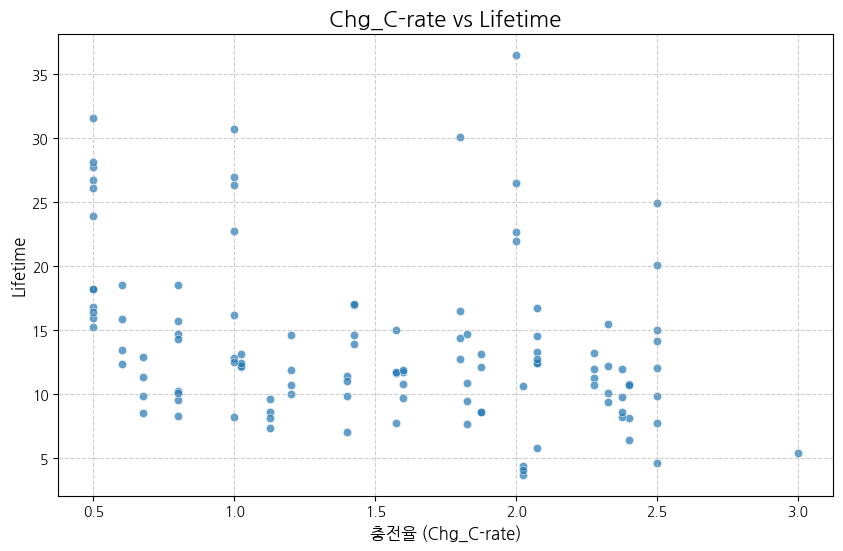

Chg_C-rate와 Lifetime 간의 상관계수: -0.31



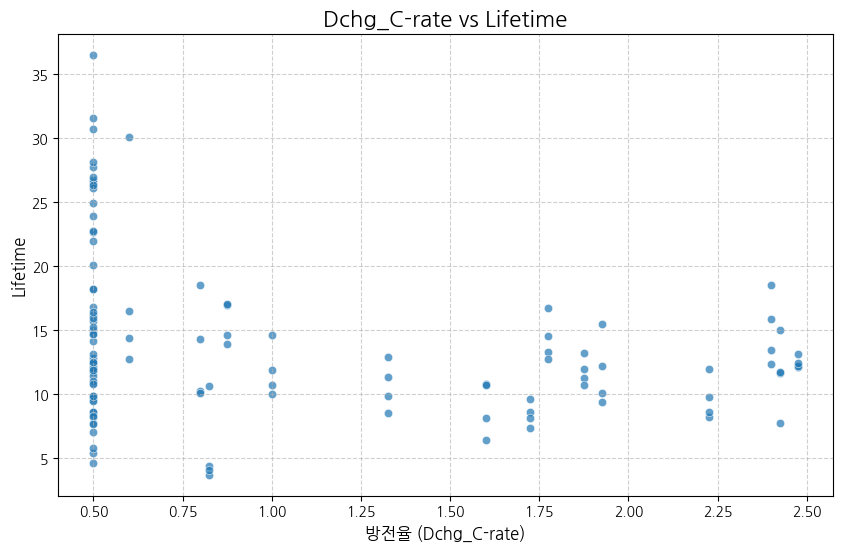

Dchg_C-rate와 Lifetime 간의 상관계수: -0.27


In [15]:
# --- 1. Chg_C-rate와 Lifetime 간의 산점도 및 상관계수 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Chg_C-rate', y='Lifetime', data=train_df, alpha=0.7)
plt.title('Chg_C-rate vs Lifetime', fontsize=16)
plt.xlabel('충전율 (Chg_C-rate)', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

correlation_chg = train_df['Chg_C-rate'].corr(train_df['Lifetime'])
print(f"Chg_C-rate와 Lifetime 간의 상관계수: {correlation_chg:.2f}\n")


# --- 2. Dchg_C-rate와 Lifetime 간의 산점도 및 상관계수 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dchg_C-rate', y='Lifetime', data=train_df, alpha=0.7)
plt.title('Dchg_C-rate vs Lifetime', fontsize=16)
plt.xlabel('방전율 (Dchg_C-rate)', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

correlation_dchg = train_df['Dchg_C-rate'].corr(train_df['Lifetime'])
print(f"Dchg_C-rate와 Lifetime 간의 상관계수: {correlation_dchg:.2f}")

배터리의 초기 전하량이나 특정 전압 구간에서의 전하량 특성이 배터리의 전체 수명(Lifetime)에 영향을 미칠 수 있다고 알려져 있어. 예를 들어, 초기 용량이 높을수록 수명이 더 길 수도 있고, 특정 전압 구간에서의 전하량 특성이 배터리의 안정성이나 열화 속도를 예측하는 데 도움이 될 수도 있지.


Q_ini와 Lifetime 간의 상관계수: -0.12

Q_ini_V_high와 Lifetime 간의 상관계수: 0.23



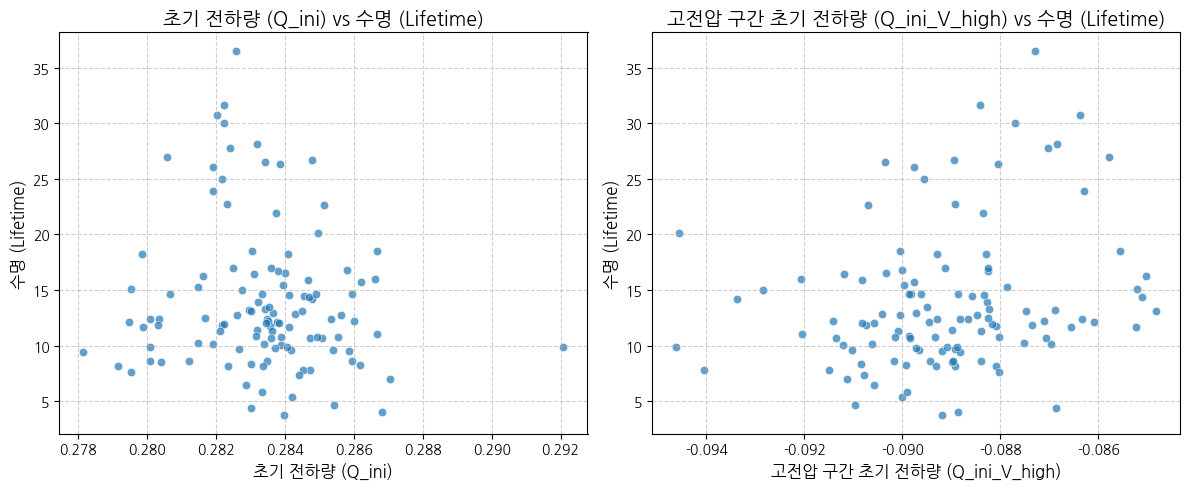

Q_ini_V_mid와 Lifetime 간의 상관계수: 0.04

Q_ini_V_low와 Lifetime 간의 상관계수: -0.12



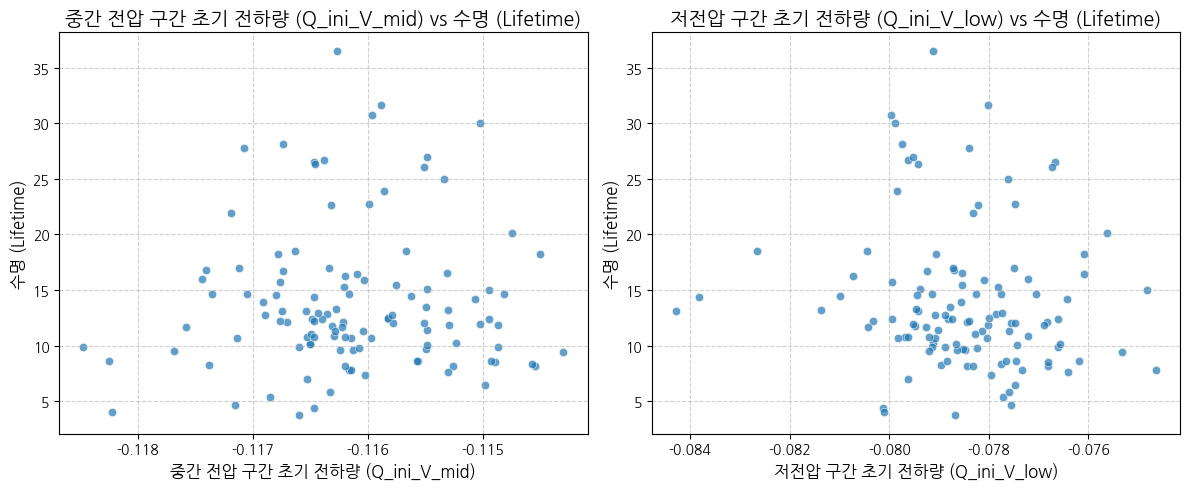

In [16]:
# --- 1. Q_ini와 Lifetime 간의 산점도 및 상관계수 ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 플롯
sns.scatterplot(x='Q_ini', y='Lifetime', data=train_df, alpha=0.7)
plt.title('초기 전하량 (Q_ini) vs 수명 (Lifetime)', fontsize=14)
plt.xlabel('초기 전하량 (Q_ini)', fontsize=12)
plt.ylabel('수명 (Lifetime)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_Q_ini_Lifetime = train_df['Q_ini'].corr(train_df['Lifetime'])
print(f"Q_ini와 Lifetime 간의 상관계수: {correlation_Q_ini_Lifetime:.2f}\n")


# --- 2. Q_ini_V_high와 Lifetime 간의 산점도 및 상관계수 ---
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 플롯
sns.scatterplot(x='Q_ini_V_high', y='Lifetime', data=train_df, alpha=0.7)
plt.title('고전압 구간 초기 전하량 (Q_ini_V_high) vs 수명 (Lifetime)', fontsize=14)
plt.xlabel('고전압 구간 초기 전하량 (Q_ini_V_high)', fontsize=12)
plt.ylabel('수명 (Lifetime)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_Q_ini_V_high_Lifetime = train_df['Q_ini_V_high'].corr(train_df['Lifetime'])
print(f"Q_ini_V_high와 Lifetime 간의 상관계수: {correlation_Q_ini_V_high_Lifetime:.2f}\n")

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()

# --- 1. Q_ini_V_mid와 Lifetime 간의 산점도 및 상관계수 ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 플롯
sns.scatterplot(x='Q_ini_V_mid', y='Lifetime', data=train_df, alpha=0.7)
plt.title('중간 전압 구간 초기 전하량 (Q_ini_V_mid) vs 수명 (Lifetime)', fontsize=14)
plt.xlabel('중간 전압 구간 초기 전하량 (Q_ini_V_mid)', fontsize=12)
plt.ylabel('수명 (Lifetime)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_Q_ini_V_mid_Lifetime = train_df['Q_ini_V_mid'].corr(train_df['Lifetime'])
print(f"Q_ini_V_mid와 Lifetime 간의 상관계수: {correlation_Q_ini_V_mid_Lifetime:.2f}\n")


# --- 2. Q_ini_V_low와 Lifetime 간의 산점도 및 상관계수 ---
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 플롯
sns.scatterplot(x='Q_ini_V_low', y='Lifetime', data=train_df, alpha=0.7)
plt.title('저전압 구간 초기 전하량 (Q_ini_V_low) vs 수명 (Lifetime)', fontsize=14)
plt.xlabel('저전압 구간 초기 전하량 (Q_ini_V_low)', fontsize=12)
plt.ylabel('수명 (Lifetime)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_Q_ini_V_low_Lifetime = train_df['Q_ini_V_low'].corr(train_df['Lifetime'])
print(f"Q_ini_V_low와 Lifetime 간의 상관계수: {correlation_Q_ini_V_low_Lifetime:.2f}\n")

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()

1. 관계가 없거나
2. 비선형적인 관계이거나
비선형관계는 아닌건지 확인해보자 

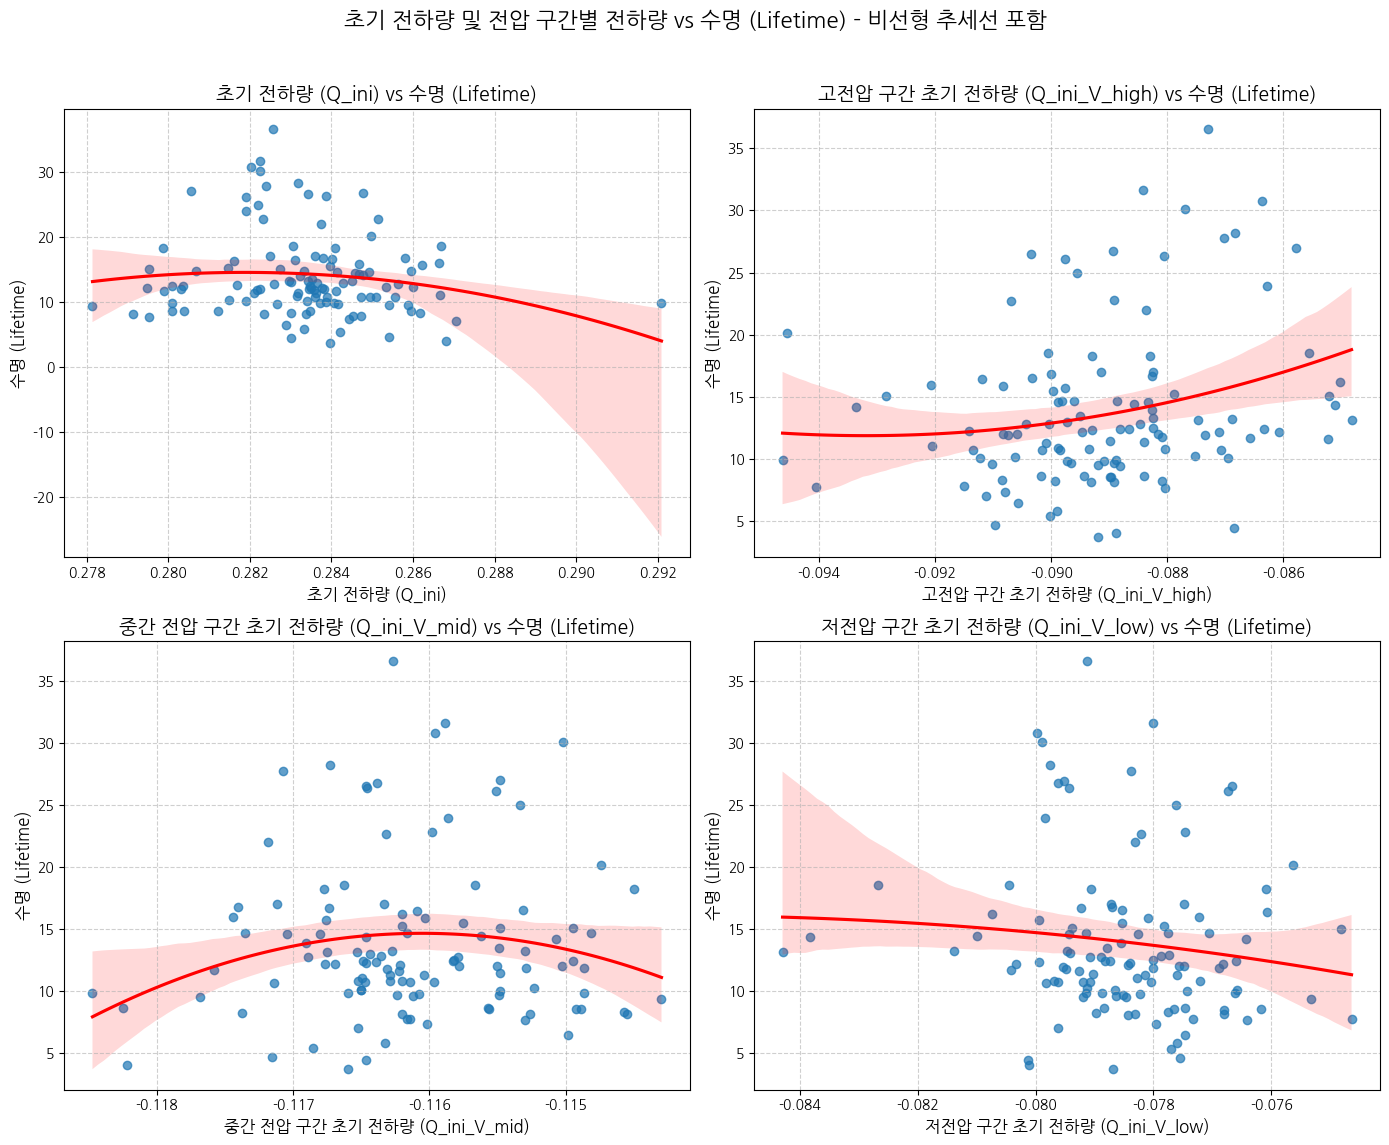

In [17]:
# --- 초기 전하량 관련 컬럼들과 Lifetime 간의 비선형 산점도 ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('초기 전하량 및 전압 구간별 전하량 vs 수명 (Lifetime) - 비선형 추세선 포함', fontsize=16)

# 1. Q_ini vs Lifetime
sns.regplot(x='Q_ini', y='Lifetime', data=train_df, ax=axes[0, 0], scatter_kws={'alpha':0.7}, line_kws={'color':'red'}, order=2)
axes[0, 0].set_title('초기 전하량 (Q_ini) vs 수명 (Lifetime)', fontsize=14)
axes[0, 0].set_xlabel('초기 전하량 (Q_ini)', fontsize=12)
axes[0, 0].set_ylabel('수명 (Lifetime)', fontsize=12)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)


# 2. Q_ini_V_high vs Lifetime
sns.regplot(x='Q_ini_V_high', y='Lifetime', data=train_df, ax=axes[0, 1], scatter_kws={'alpha':0.7}, line_kws={'color':'red'}, order=2)
axes[0, 1].set_title('고전압 구간 초기 전하량 (Q_ini_V_high) vs 수명 (Lifetime)', fontsize=14)
axes[0, 1].set_xlabel('고전압 구간 초기 전하량 (Q_ini_V_high)', fontsize=12)
axes[0, 1].set_ylabel('수명 (Lifetime)', fontsize=12)
axes[0, 1].grid(True, linestyle='--', alpha=0.6)


# 3. Q_ini_V_mid vs Lifetime
# 오타 수정: line_kns -> line_kws
sns.regplot(x='Q_ini_V_mid', y='Lifetime', data=train_df, ax=axes[1, 0], scatter_kws={'alpha':0.7}, line_kws={'color':'red'}, order=2)
axes[1, 0].set_title('중간 전압 구간 초기 전하량 (Q_ini_V_mid) vs 수명 (Lifetime)', fontsize=14)
axes[1, 0].set_xlabel('중간 전압 구간 초기 전하량 (Q_ini_V_mid)', fontsize=12)
axes[1, 0].set_ylabel('수명 (Lifetime)', fontsize=12)
axes[1, 0].grid(True, linestyle='--', alpha=0.6)


# 4. Q_ini_V_low vs Lifetime
sns.regplot(x='Q_ini_V_low', y='Lifetime', data=train_df, ax=axes[1, 1], scatter_kws={'alpha':0.7}, line_kws={'color':'red'}, order=2)
axes[1, 1].set_title('저전압 구간 초기 전하량 (Q_ini_V_low) vs 수명 (Lifetime)', fontsize=14)
axes[1, 1].set_xlabel('저전압 구간 초기 전하량 (Q_ini_V_low)', fontsize=12)
axes[1, 1].set_ylabel('수명 (Lifetime)', fontsize=12)
axes[1, 1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # 전체 레이아웃 조정 (제목 공간 확보)
plt.show()

높은 분산, 추세선이 데이터의 패턴을 포착하지 못함.
>비선형적인 관계에서도 유의미한 결과를 보여주지 않는다.
초기 모델링 단계에서는 제외하고 강한 상관관계를 보이는 변수들에 집중해서 베이스라인을 만드는 것이 좋을 것 같음

avg_stress와 Lifetime 간의 선형 상관계수: -0.72
multi_stress와 Lifetime 간의 선형 상관계수: -0.65
chg_stress와 Lifetime 간의 선형 상관계수: -0.57
dchg_stress와 Lifetime 간의 선형 상관계수: -0.48


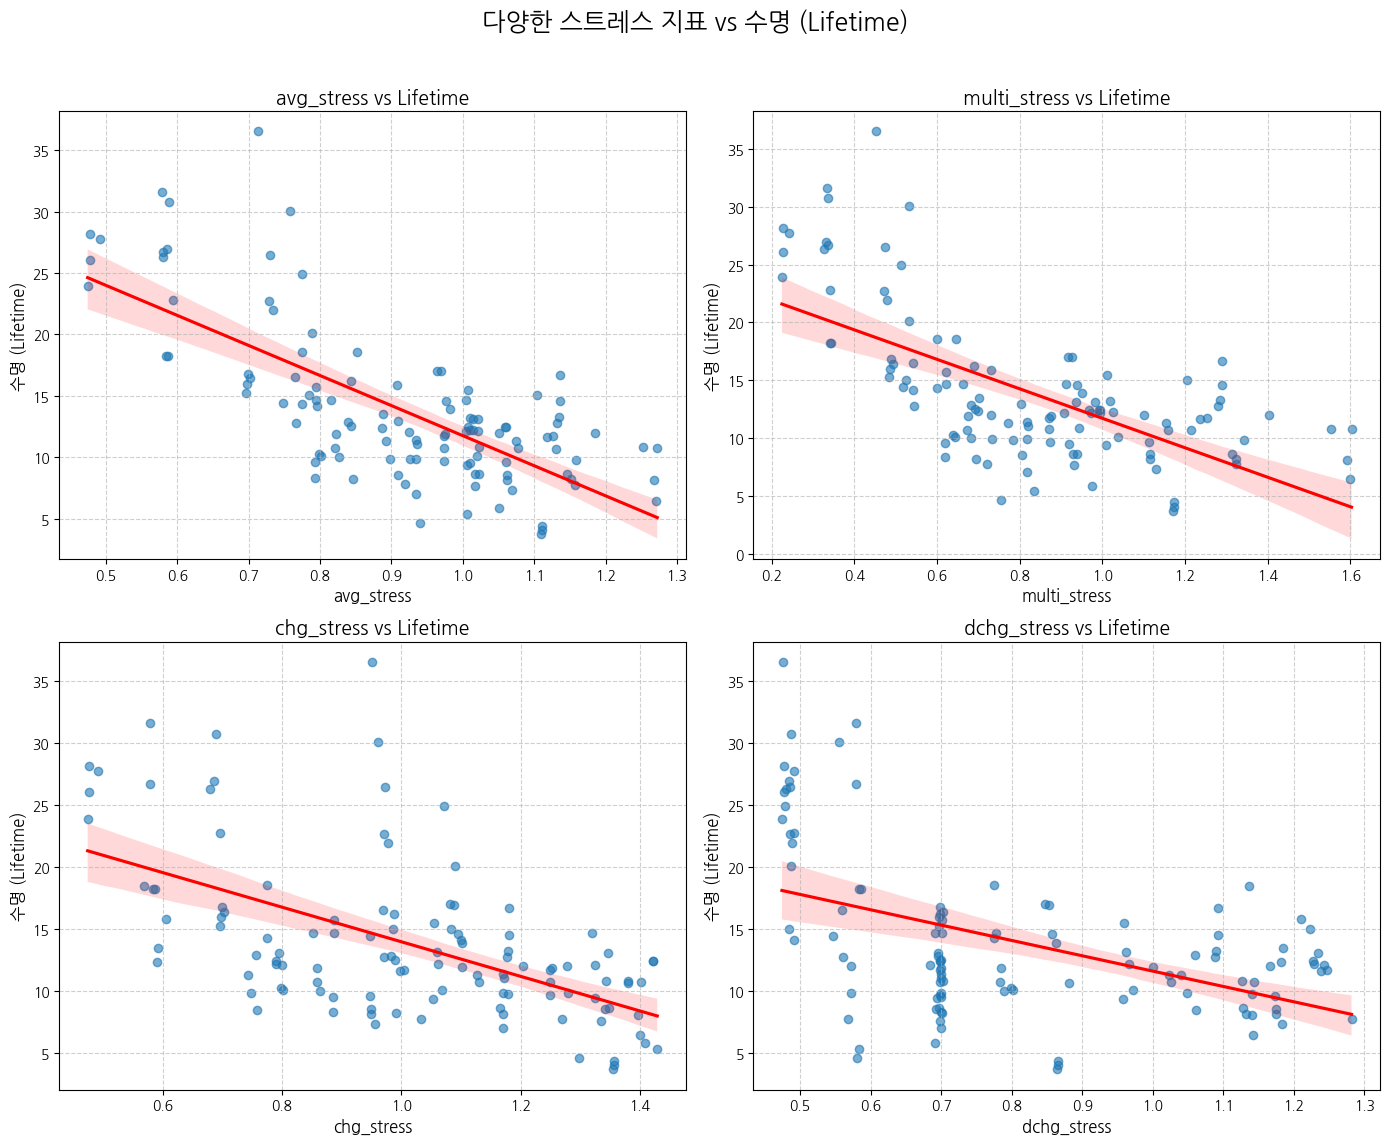

In [18]:
# --- 스트레스 관련 컬럼들과 Lifetime 간의 산점도 및 상관계수 ---
stress_cols = ['avg_stress', 'multi_stress', 'chg_stress', 'dchg_stress']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('다양한 스트레스 지표 vs 수명 (Lifetime)', fontsize=18)

axes_flat = axes.flatten() # 2x2 배열을 1차원으로 펼쳐서 반복문 사용 용이하게 함

for i, col in enumerate(stress_cols):
    sns.regplot(x=col, y='Lifetime', data=train_df, ax=axes_flat[i], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    axes_flat[i].set_title(f'{col} vs Lifetime', fontsize=14)
    axes_flat[i].set_xlabel(col, fontsize=12)
    axes_flat[i].set_ylabel('수명 (Lifetime)', fontsize=12)
    axes_flat[i].grid(True, linestyle='--', alpha=0.6)

    correlation = train_df[col].corr(train_df['Lifetime'])
    print(f"{col}와 Lifetime 간의 선형 상관계수: {correlation:.2f}")

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # 전체 레이아웃 조정 (제목 공간 확보)
plt.show()


음의 상관관계지만 점이 넓게 퍼져있는 것으로 봐선 이 변수만으로 lifetime의 모든 변화를 완벽하게 설명할 수는 없다는 의미임

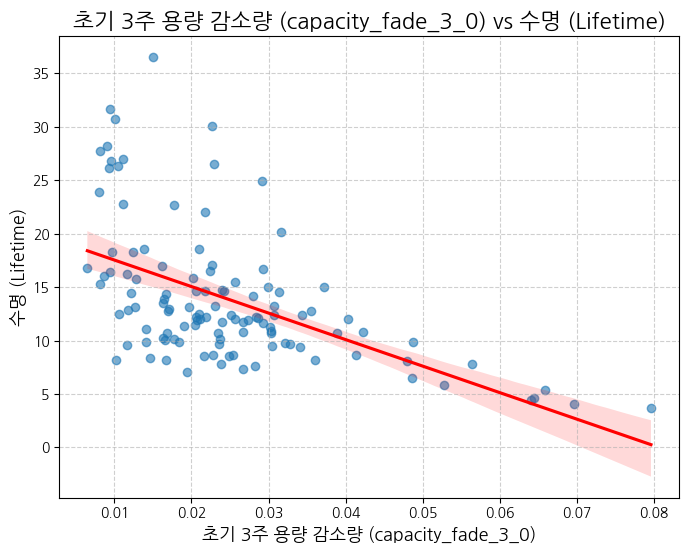

capacity_fade_3_0와 Lifetime 간의 선형 상관계수: -0.54


In [19]:
# --- capacity_fade_3_0와 Lifetime 간의 산점도 및 상관계수 ---
plt.figure(figsize=(8, 6))
sns.regplot(x='capacity_fade_3_0', y='Lifetime', data=train_df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('초기 3주 용량 감소량 (capacity_fade_3_0) vs 수명 (Lifetime)', fontsize=16)
plt.xlabel('초기 3주 용량 감소량 (capacity_fade_3_0)', fontsize=13)
plt.ylabel('수명 (Lifetime)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

correlation_capacity_fade_3_0_Lifetime = train_df['capacity_fade_3_0'].corr(train_df['Lifetime'])
print(f"capacity_fade_3_0와 Lifetime 간의 선형 상관계수: {correlation_capacity_fade_3_0_Lifetime:.2f}")


강력한 음의 선형관계 :
용량감소가 클수록 배터리 수명이 짧다는 걸 보여준다. 
낮은 분산:
lifetime의 변화를 상당히 잘 설명할 수 잇다.
>> 예측 모델의 핵심 변수가 될 가능성이 잇다. 

delta_Q_DVA1와 Lifetime 간의 선형 상관계수: -0.09
delta_Q_DVA2와 Lifetime 간의 선형 상관계수: -0.43
delta_Q_DVA3와 Lifetime 간의 선형 상관계수: -0.46
delta_Q_DVA4와 Lifetime 간의 선형 상관계수: -0.37


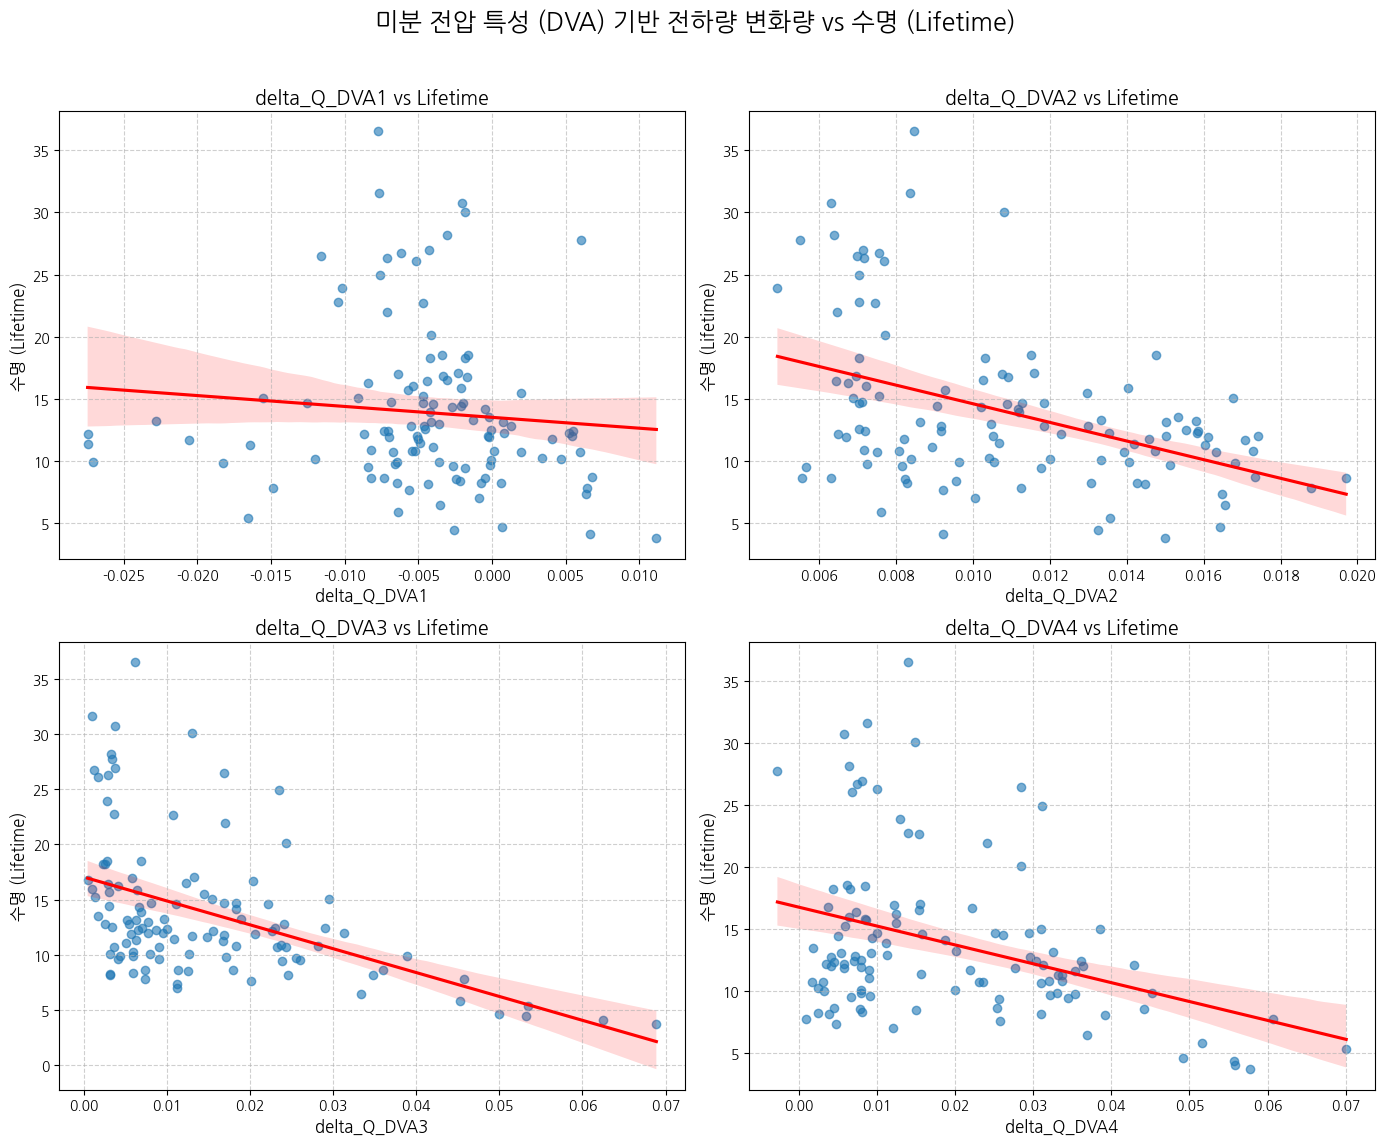

In [20]:
# --- DVA 기반 전하량 변화량 컬럼들과 Lifetime 간의 산점도 및 상관계수 ---
dva_cols = ['delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('미분 전압 특성 (DVA) 기반 전하량 변화량 vs 수명 (Lifetime)', fontsize=18)

axes_flat = axes.flatten() # 2x2 배열을 1차원으로 펼쳐서 반복문 사용 용이하게 함

for i, col in enumerate(dva_cols):
    sns.regplot(x=col, y='Lifetime', data=train_df, ax=axes_flat[i], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    axes_flat[i].set_title(f'{col} vs Lifetime', fontsize=14)
    axes_flat[i].set_xlabel(col, fontsize=12)
    axes_flat[i].set_ylabel('수명 (Lifetime)', fontsize=12)
    axes_flat[i].grid(True, linestyle='--', alpha=0.6)

    correlation = train_df[col].corr(train_df['Lifetime'])
    print(f"{col}와 Lifetime 간의 선형 상관계수: {correlation:.2f}")

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # 전체 레이아웃 조정 (제목 공간 확보)
plt.show()


--- delta_Q_DVA 컬럼들 간의 상관 행렬 ---
              delta_Q_DVA1  delta_Q_DVA2  delta_Q_DVA3  delta_Q_DVA4
delta_Q_DVA1      1.000000      0.167388     -0.029552     -0.467628
delta_Q_DVA2      0.167388      1.000000      0.085291      0.001523
delta_Q_DVA3     -0.029552      0.085291      1.000000      0.897358
delta_Q_DVA4     -0.467628      0.001523      0.897358      1.000000




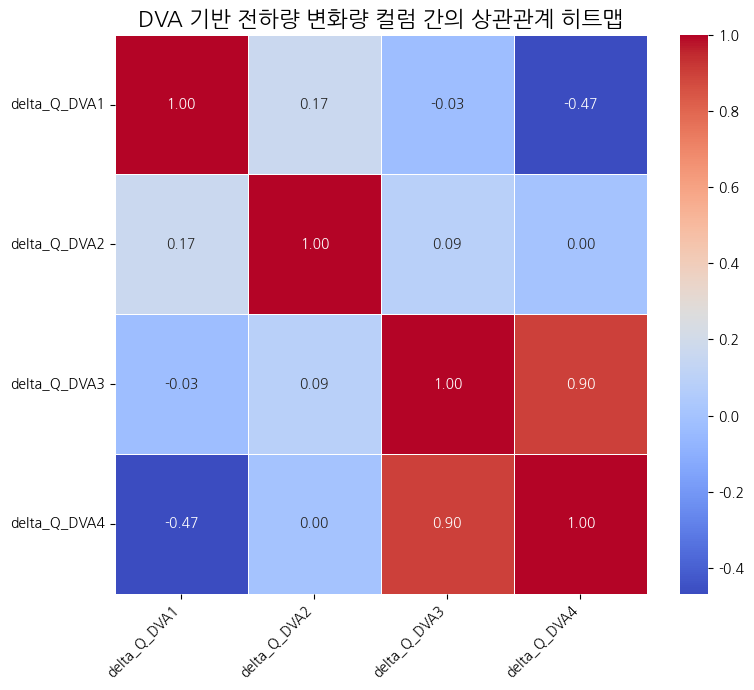

In [21]:
# --- delta_Q_DVA 컬럼들 간의 상관 행렬 및 히트맵 ---
dva_cols_to_correlate = ['delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4']
correlation_matrix = train_df[dva_cols_to_correlate].corr()

print("--- delta_Q_DVA 컬럼들 간의 상관 행렬 ---")
print(correlation_matrix)
print("\n")

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('DVA 기반 전하량 변화량 컬럼 간의 상관관계 히트맵', fontsize=16)
plt.xticks(rotation=45, ha='right') # x축 레이블 회전
plt.yticks(rotation=0) # y축 레이블 회전
plt.tight_layout()
plt.show()


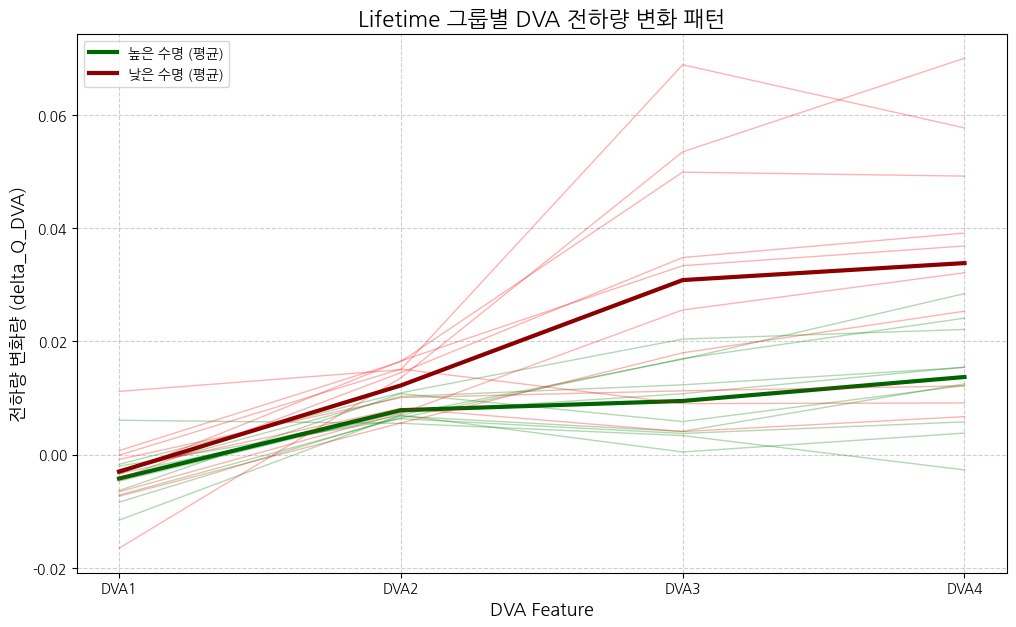

In [22]:
# --- Lifetime 기준으로 그룹 나누기 ---
# 예시로 Lifetime 상위 25%와 하위 25%를 나누어 'High Lifetime'과 'Low Lifetime' 그룹으로 정의
# 실제 데이터의 분포를 보고 이 임계값을 조정해야 함
lifetime_threshold_high = train_df['Lifetime'].quantile(0.75) # 상위 25% 이상
lifetime_threshold_low = train_df['Lifetime'].quantile(0.25)  # 하위 25% 이하

high_lifetime_batteries = train_df[train_df['Lifetime'] >= lifetime_threshold_high].head(10) # 상위 10개 샘플
low_lifetime_batteries = train_df[train_df['Lifetime'] <= lifetime_threshold_low].head(10)   # 하위 10개 샘플

# DVA 컬럼 목록
dva_cols = ['delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4']
dva_labels = ['DVA1', 'DVA2', 'DVA3', 'DVA4'] # X축 레이블을 위한 리스트

plt.figure(figsize=(12, 7))
plt.title('Lifetime 그룹별 DVA 전하량 변화 패턴', fontsize=16)
plt.xlabel('DVA Feature', fontsize=13)
plt.ylabel('전하량 변화량 (delta_Q_DVA)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(len(dva_labels)), labels=dva_labels) # X축 레이블 설정

# High Lifetime 그룹 패턴 그리기
for idx, row in high_lifetime_batteries.iterrows():
    plt.plot(dva_labels, row[dva_cols], color='green', alpha=0.3, linewidth=1)
# High Lifetime 그룹 평균 패턴
plt.plot(dva_labels, high_lifetime_batteries[dva_cols].mean(), color='darkgreen', linewidth=3, label='높은 수명 (평균)')

# Low Lifetime 그룹 패턴 그리기
for idx, row in low_lifetime_batteries.iterrows():
    plt.plot(dva_labels, row[dva_cols], color='red', alpha=0.3, linewidth=1)
# Low Lifetime 그룹 평균 패턴
plt.plot(dva_labels, low_lifetime_batteries[dva_cols].mean(), color='darkred', linewidth=3, label='낮은 수명 (평균)')

plt.legend()
plt.show()


배터리 수명이 긴 애들(초록) VS 수명이 짧은 애들(빨간)
진한선:평균, 옅은 선: 각각

DVA1, DVA2, DV3, DVA4: 전기를 충전하거나 방전할때 배터리 안에서 중요한 반응이 일어나는 위치

0에 가까우면: 거의 안 바뀜,
0에서 멀어지면: 많이 바뀜

> 수명이 짧은 배터리는 안에서 전기 저장량이 훨씬 많이 변햇어, 많이 손상되었어
배터리 수명을 예측하려면 DVA3, DVA4에서의 변화량이 핵심이구나! 


DVA_Slope_3_4 (DVA3에서 DVA4로의 변화량) 변수 생성:

DVA4 - DVA3 로 계산하는 거야.

이 변수는 Lifetime이 낮은 배터리에서 더 큰 양수 값을 가질 것이고, 높은 배터리에서는 작거나 음수 값을 가질 가능성이 높아. 즉, Lifetime과 강한 음의 상관관계를 보일 것으로 예상돼.

이 변수 하나만으로도 Lifetime을 예측하는 데 큰 기여를 할 수 있을 거야.

DVA_Overall_Change (DVA1에서 DVA4로의 전체 변화량) 변수 생성:

DVA4 - DVA1 로 계산하는 거야.

이 변수는 DVA 패턴의 전체적인 폭을 나타내. 마찬가지로 Lifetime이 낮은 배터리에서 더 큰 값을 가질 가능성이 높지.

mean_dqdv_dchg_3_0와 Lifetime 간의 선형 상관계수: -0.54
var_dqdv_dchg_3_0와 Lifetime 간의 선형 상관계수: -0.52


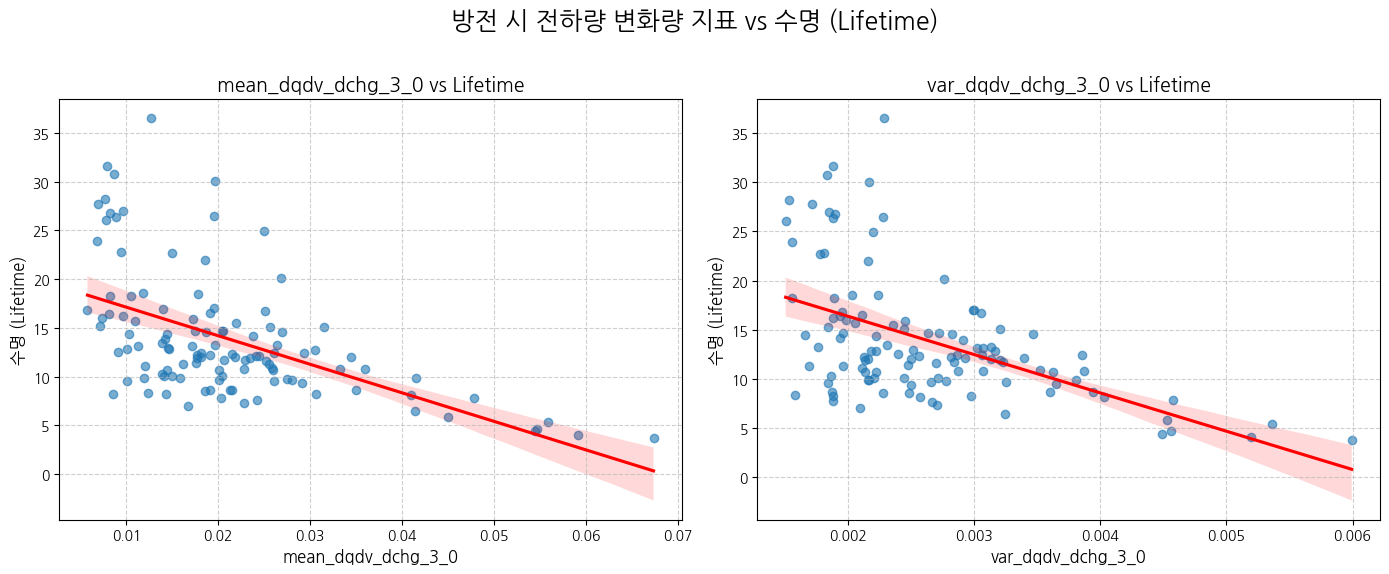

In [23]:
# --- 방전 시 전하량 변화량의 평균/분산과 Lifetime 간의 산점도 및 상관계수 ---
dqdv_cols = ['mean_dqdv_dchg_3_0', 'var_dqdv_dchg_3_0']

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # 1행 2열로 그래프를 그림
fig.suptitle('방전 시 전하량 변화량 지표 vs 수명 (Lifetime)', fontsize=18)

axes_flat = axes.flatten() # 1차원으로 펼쳐서 반복문 사용 용이하게 함

for i, col in enumerate(dqdv_cols):
    sns.regplot(x=col, y='Lifetime', data=train_df, ax=axes_flat[i], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    axes_flat[i].set_title(f'{col} vs Lifetime', fontsize=14)
    axes_flat[i].set_xlabel(col, fontsize=12)
    axes_flat[i].set_ylabel('수명 (Lifetime)', fontsize=12)
    axes_flat[i].grid(True, linestyle='--', alpha=0.6)

    correlation = train_df[col].corr(train_df['Lifetime'])
    print(f"{col}와 Lifetime 간의 선형 상관계수: {correlation:.2f}")

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # 전체 레이아웃 조정 (제목 공간 확보)
plt.show()

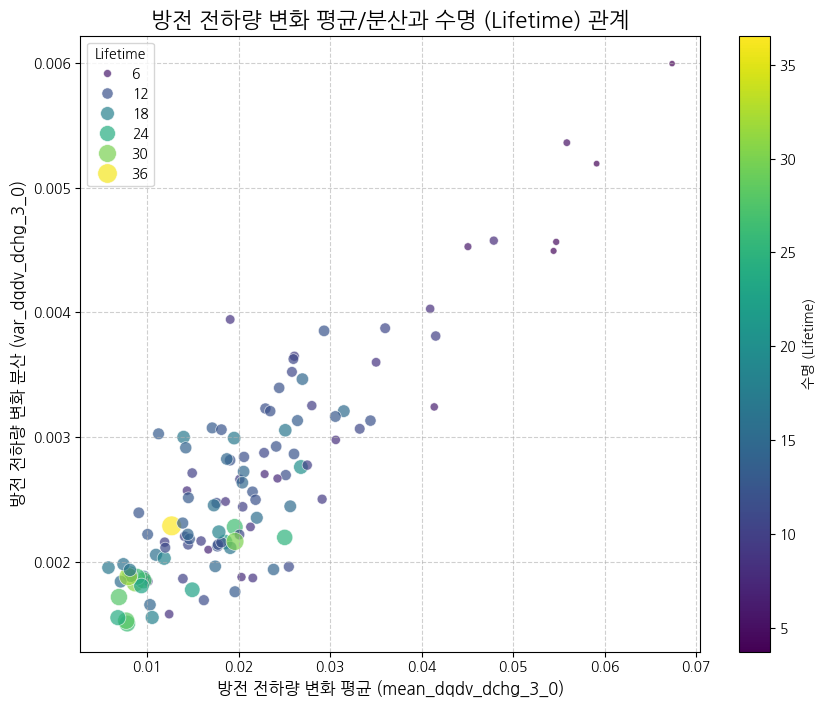

In [24]:
# --- mean_dqdv_dchg_3_0, var_dqdv_dchg_3_0, Lifetime 간의 관계 시각화 (Lifetime을 색상으로) ---
plt.figure(figsize=(10, 8))

# scatterplot 함수가 반환하는 Axes 객체를 `ax` 변수에 저장
# 이때, 컬러맵과 정규화를 위해 `cmap`과 `norm`을 설정
# `vmin`과 `vmax`를 사용하여 컬러바의 스케일을 Lifetime 범위에 맞춤
sct = sns.scatterplot(x='mean_dqdv_dchg_3_0', y='var_dqdv_dchg_3_0', hue='Lifetime', data=train_df,
                      palette='viridis', size='Lifetime', sizes=(20, 200), alpha=0.7,
                      hue_norm=(train_df['Lifetime'].min(), train_df['Lifetime'].max())) # hue_norm 추가

plt.title('방전 전하량 변화 평균/분산과 수명 (Lifetime) 관계', fontsize=16)
plt.xlabel('방전 전하량 변화 평균 (mean_dqdv_dchg_3_0)', fontsize=12)
plt.ylabel('방전 전하량 변화 분산 (var_dqdv_dchg_3_0)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# `scatterplot`이 반환하는 `mappable` 객체를 `legend` 대신 직접 사용하여 컬러바 생성
# `sct.legend_.colorbar`는 `scatterplot`의 `hue`가 생성한 컬러바를 참조할 때 사용
# 하지만 일반적인 `plt.colorbar()`와는 사용법이 달라서 직접 `matplotlib.cm.ScalarMappable`을 사용하거나,
# `seaborn`에서 `cbar_kws`를 사용하지 않는 한, `sct` 객체 자체를 컬러바의 `mappable`로 사용하는 것이 일반적임.

# 가장 간단한 해결책은 seaborn의 hue에 의해 자동으로 생성되는 colorbar를 활용하거나,
# `matplotlib.cm.ScalarMappable`을 명시적으로 사용하는 것.
# 여기서는 scatterplot이 이미 hue를 처리했으므로, pyplot의 colorbar를 사용하려면
# 가상의 mappable 객체를 생성하여 연결해야 함.

# 가장 쉬운 방법으로, seaborn의 scatterplot이 반환하는 legend 객체를 활용하거나
# 혹은 colorbar를 명시적으로 생성하는 방법을 사용합니다.

# Option 1: `hue_norm`을 통해 Seaborn이 자체적으로 컬러바를 잘 만들도록 유도
# 위 scatterplot에 `hue_norm`을 추가함으로써 Seaborn이 컬러바를 더 잘 처리하도록 함.
# 하지만 여전히 `plt.colorbar()`는 `mappable`이 필요하므로, 이 경우에는 수동으로 생성해야 함.

# Option 2: `ScalarMappable`을 명시적으로 생성하여 컬러바에 전달 (가장 안정적)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=train_df['Lifetime'].min(), vmax=train_df['Lifetime'].max()))
sm.set_array([]) # 더미 배열 설정 (필수)
cbar = plt.colorbar(sm, ax=plt.gca(), label='수명 (Lifetime)')


plt.show()



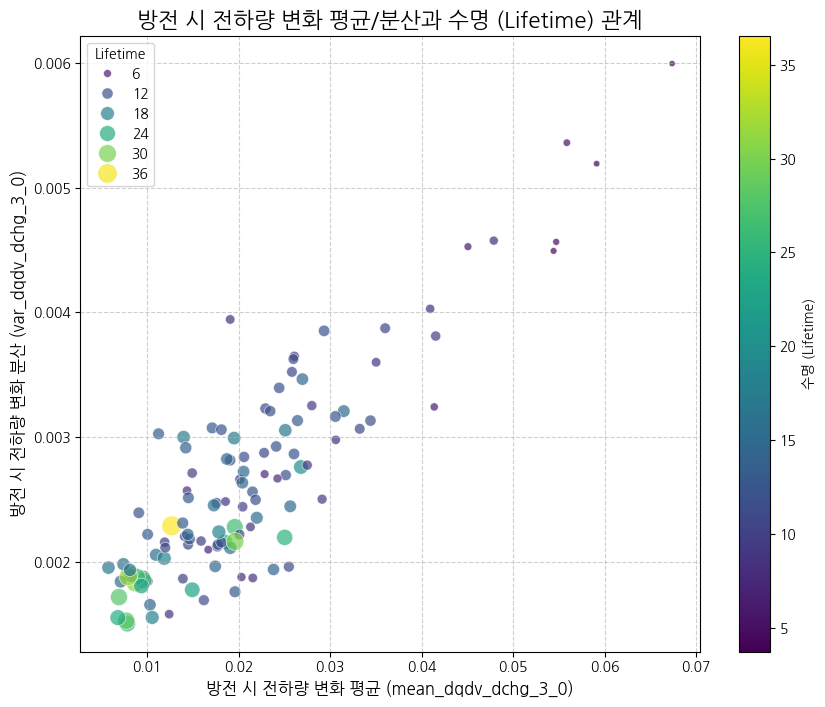

In [25]:
# --- mean_dqdv_dchg_3_0, var_dqdv_dchg_3_0, Lifetime 간의 관계 시각화 (Lifetime을 색상으로) ---
plt.figure(figsize=(10, 8))

# scatterplot 함수를 사용하여 Lifetime을 hue와 size로 매핑
sct = sns.scatterplot(x='mean_dqdv_dchg_3_0', y='var_dqdv_dchg_3_0', hue='Lifetime', data=train_df,
                      palette='viridis', size='Lifetime', sizes=(20, 200), alpha=0.7,
                      hue_norm=(train_df['Lifetime'].min(), train_df['Lifetime'].max()))

plt.title('방전 시 전하량 변화 평균/분산과 수명 (Lifetime) 관계', fontsize=16)
plt.xlabel('방전 시 전하량 변화 평균 (mean_dqdv_dchg_3_0)', fontsize=12)
plt.ylabel('방전 시 전하량 변화 분산 (var_dqdv_dchg_3_0)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# ScalarMappable을 명시적으로 생성하여 컬러바에 전달 (가장 안정적인 방법)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=train_df['Lifetime'].min(), vmax=train_df['Lifetime'].max()))
sm.set_array([]) # 더미 배열 설정 (필수)
cbar = plt.colorbar(sm, ax=plt.gca(), label='수명 (Lifetime)') # 컬러바 추가

plt.show()


mean_dqdv_dchg_high_3_0와 Lifetime 간의 선형 상관계수: -0.49
var_dqdv_dchg_high_3_0와 Lifetime 간의 선형 상관계수: -0.45
mean_dqdv_dchg_mid_3_0와 Lifetime 간의 선형 상관계수: -0.74
var_dqdv_dchg_mid_3_0와 Lifetime 간의 선형 상관계수: 0.29
mean_dqdv_dchg_low_3_0와 Lifetime 간의 선형 상관계수: -0.40
var_dqdv_dchg_low_3_0와 Lifetime 간의 선형 상관계수: -0.44


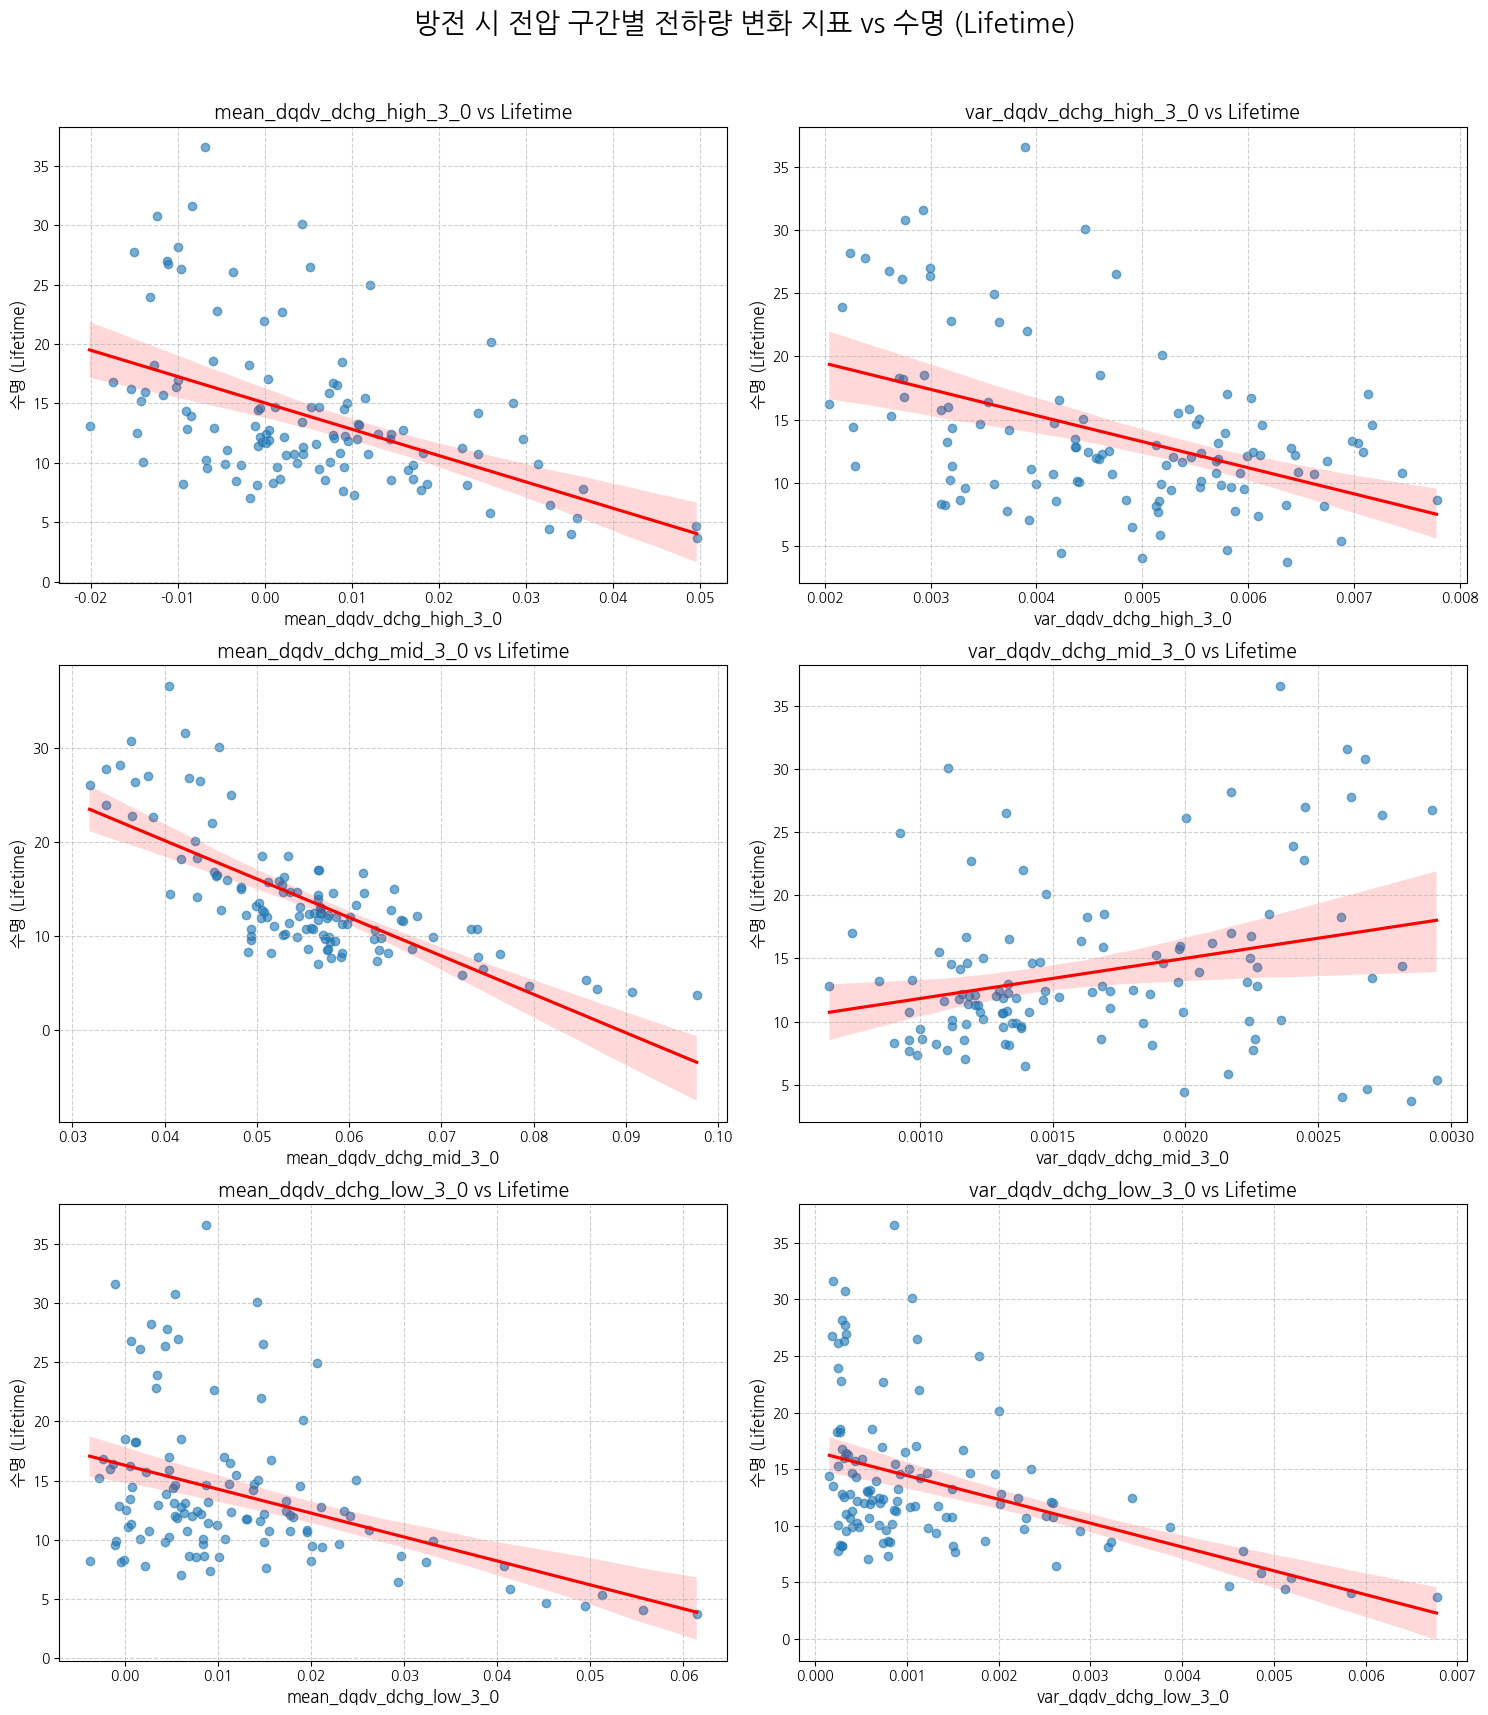

In [26]:
# --- 고전압/중간전압/저전압 구간의 평균/분산과 Lifetime 간의 산점도 및 상관계수 ---
dqdv_segment_cols = [
    'mean_dqdv_dchg_high_3_0', 'var_dqdv_dchg_high_3_0',
    'mean_dqdv_dchg_mid_3_0', 'var_dqdv_dchg_mid_3_0',
    'mean_dqdv_dchg_low_3_0', 'var_dqdv_dchg_low_3_0'
]

fig, axes = plt.subplots(3, 2, figsize=(15, 18)) # 3행 2열로 그래프를 그림
fig.suptitle('방전 시 전압 구간별 전하량 변화 지표 vs 수명 (Lifetime)', fontsize=20)

axes_flat = axes.flatten() # 1차원으로 펼쳐서 반복문 사용 용이하게 함

for i, col in enumerate(dqdv_segment_cols):
    sns.regplot(x=col, y='Lifetime', data=train_df, ax=axes_flat[i], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    axes_flat[i].set_title(f'{col} vs Lifetime', fontsize=14)
    axes_flat[i].set_xlabel(col, fontsize=12)
    axes_flat[i].set_ylabel('수명 (Lifetime)', fontsize=12)
    axes_flat[i].grid(True, linestyle='--', alpha=0.6)

    correlation = train_df[col].corr(train_df['Lifetime'])
    print(f"{col}와 Lifetime 간의 선형 상관계수: {correlation:.2f}")

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # 전체 레이아웃 조정 (제목 공간 확보)
plt.show()


In [27]:
# index의 정보를 확인합니다.
train_df.index

Index(['1031U', '1101F', '1138K', '1179M', '1240W', '1303Y', '1397U', '1441V',
       '1454Q', '1513R',
       ...
       '9067Q', '9090C', '9108V', '9349O', '9373N', '9627Y', '9833F', '9835L',
       '9897W', '9908R'],
      dtype='object', name='Cell_ID', length=116)


# ------------------------------------------------------------
불러온 평가용 데이터의 일부를 확인해봅시다.

In [28]:
test_x.head()

,CV_time_0,CV_time_3,Chg_C-rate,Dchg_C-rate,DoD,Q_ini,Q_ini_V_high,Q_ini_V_low,Q_ini_V_mid,Q_initial,...,mean_dqdv_dchg_mid_3_0,min_deltaQ,multi_stress,skew_deltaQ,var_deltaQ,var_deltaQ_dchg_3_0,var_dqdv_dchg_3_0,var_dqdv_dchg_high_3_0,var_dqdv_dchg_low_3_0,var_dqdv_dchg_mid_3_0
Cell_ID,,,,,,,,,,,,,,,,,,,,,
1065Q,1168.0,686.0,1.325,1.825,0.325687,0.282856,-0.088439,-0.078890,-0.116076,0.282856,...,0.036362,-0.014704,0.506454,0.552347,0.000063,0.000063,0.001884,0.004551,0.000617,0.000646
1088R,1021.0,713.0,1.800,0.500,0.976176,0.280780,-0.087853,-0.077446,-0.115675,0.280780,...,0.060289,-0.035938,0.926081,0.236711,0.000259,0.000259,0.003657,0.006232,0.002375,0.002325
1235T,953.0,643.0,2.500,0.500,0.279847,0.283415,-0.091363,-0.076429,-0.115763,0.283415,...,0.033338,-0.022460,0.312878,0.163569,0.000106,0.000106,0.002283,0.003582,0.001981,0.001205
1479K,1145.0,733.0,2.125,1.975,0.530650,0.283360,-0.088303,-0.078583,-0.116972,0.283360,...,0.057076,-0.026895,1.087104,0.593676,0.000145,0.000145,0.002631,0.005570,0.000933,0.001377
1552R,958.0,775.0,1.175,1.425,0.907451,0.283518,-0.092992,-0.075567,-0.115559,0.283518,...,0.060685,-0.023440,1.174220,0.735341,0.000097,0.000097,0.001953,0.004097,0.000276,0.000441


In [29]:
print("Train Data 크기 :", train_df.shape)
print("Test Data 크기 :", test_x.shape)

Train Data 크기 : (116, 36)
Test Data 크기 : (109, 34)


## 데이터 전처리

1. 결측치가 있는지 확인합니다.

In [30]:
na_columns_train = train_x.columns[train_x.isna().any()]
na_columns_test = test_x.columns[test_x.isna().any()]
na_columns = set(na_columns_train) | set(na_columns_test)
na_columns

set()

2. 데이터를 정규화 합니다.

In [31]:
# 데이터 정규화

scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

In [32]:
print("Train Data 크기 :", train_x.shape)
print("Test Data 크기 :", test_x.shape)

Train Data 크기 : (116, 34)
Test Data 크기 : (109, 34)


## 모델 학습

모델은 각자 자유롭게 구성할 수 있으며, 올바른 형식으로 `submission.csv`를 작성한다면 다양한 모델이 허용됩니다.

아래는 이해를 돕기 위한 예시 코드로, 간단한 서포트 벡터 머신 기반 회귀 예측 모델 (SVR) 을 사용합니다.

In [33]:
model = SVR()
model.fit(train_x, train_y)

SVR()

학습 데이터에 대한 성능을 확인합니다.

In [34]:
pred_train = model.predict(train_x)
print("MAPE Score for Train: ", mean_absolute_percentage_error(train_y, pred_train))

MAPE Score for Train:  0.3372056399070536


## 모델 평가 및 결과 저장

회귀 모델을 평가하기 위한 지표는 다양하게 있으며, 저희는 그 중에서 **MAPE Score** 지표를 활용하여 순위를 결정할 것입니다.

여러분들이 작성하신 모델의 성능을 평가하기 위해서는, 지시사항에 나와 있는 대로 **테스트 데이터**를 불러와서 예측을 수행하고, 그 결과를 반드시 `submission.csv` 파일에 기록하여 제출해야 합니다.

In [35]:
# 제출 템플릿을 불러옵니다.
submission = pd.read_csv("submission.csv", index_col=0)

# 테스트 데이터에 대한 예측 결과를 저장합니다.
# Note. 예시 코드에서는 index(Cell_ID)의 순서를 수정하지 않아서 예측 결과를 바로 템플릿에 할당했지만, 
# 만약 학습 과정에서 index를 수정하셨다면, sort_index() 등으로 index를 맞추는 것을 권장 드립니다.
submission["Lifetime"] = model.predict(test_x)
submission.to_csv("submission.csv")

### 결과 검증

`submission.csv` 파일을 다시 불러와 올바르게 값을 채웠는지 다시 한번 확인합니다.

In [36]:
submission = pd.read_csv("submission.csv", index_col=0)
submission

,Lifetime
Cell_ID,
1065Q,12.569012
1088R,12.226048
1235T,12.132744
1479K,12.487233
1552R,12.042100
...,...
9242Y,12.083966
9601Y,12.603540
9726A,12.472272


### 제출

`submission.csv` 파일이 제대로 생성됐다면, 우측 상단의 제출 버튼을 눌러 `submission.csv` 파일을 제출하고 리더보드에서 점수를 확인하세요.

- 팀당 제출 가능 횟수는 **1일 20회** 입니다. 팀 내 모든 구성원이 제출 가능하나 팀 제출 횟수는 팀 단위로 합산됩니다.
- 최종 채점 기준: Private score 50% + Public score 50%
- 리더보드에는 **마지막으로 제출한 결과**의 Public 점수가 공개됩니다.
- 최종 채점에는 마지막으로 제출된 결과로 평가됩니다.

## 경진대회 종료 전 제출을 희망하는 코드와 결과물로 마지막 제출을 수행하세요.
## 반드시 마지막 제출된 프로젝트의 전체 파일을 압축하여 별도의 제출 공간에 제출하세요.

다음 파일들을 압축하여 별도의 제출공간에 제출해야 합니다.
- `code.ipynb`: 전체 프로젝트 진행 파일
- `submission.csv`: 예측 결과 파일
- 외부 데이터 사용 시: 원본 데이터 파일(혹은 데이터 다운로드 코드)
    - 외부 데이터에 대한 전처리 과정은 프로젝트 코드 내에 포함되어야 함
- 기타 프로젝트 실행에 필요한 모든 파일